In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression
import seaborn.objects as so

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
final_results_path = "results/final"
experiment_config = ["backend", "model_type", "model_complexity", "precision", "seed"]
output_format = "pdf"

Before all, a dataframe with all experiments' configuration and CSV paths is defined, for easier data manipulation.

In [3]:
# Dictionary to store the data
rows = []
error_rows = []

# Iterate through the seed folders
for seed in os.listdir(final_results_path):
    seed_path = os.path.join(final_results_path, seed)
    
    # Check that it is a directory
    if os.path.isdir(seed_path):

        # Iterate through the model folders inside each seed
        for folder in os.listdir(seed_path):
            folder_path = os.path.join(seed_path, folder)

            if not os.path.isdir(folder_path):
                continue

            # Extract info from folder name
            # Precision can contain _, so a workaround is needed
            timestamp, backend, model, model_complexity, right = folder.split("_", 4)
            precision, _ = right.rsplit("_", 1) # precision, seed

            experiment_info = {
                "timestamp": timestamp,
                "backend": backend,
                "model_type": model,
                "model_complexity": model_complexity,
                "precision": precision,
                "seed": seed,
            }

            if "error.txt" in os.listdir(folder_path):
                error_rows.append({
                    **experiment_info,
                    "path": os.path.join(folder_path, "error.txt")
                })
                continue

            # Add csv files' info
            for file in os.listdir(folder_path):
                if file.endswith(".csv"):
                    rows.append({
                        **experiment_info,
                        "filename": os.path.splitext(file)[0],  # Name without extension
                        "path": os.path.join(folder_path, file)
                    })


index_df = pd.DataFrame(rows)
error_df = pd.DataFrame(error_rows)

In [4]:
index_df.head()

timestamp backend model_type model_complexity precision seed  \
0  20250724-142036   torch        mlp           simple      fp32   42   
1  20250724-142036   torch        mlp           simple      fp32   42   
2  20250724-142036   torch        mlp           simple      fp32   42   
3  20250724-142036   torch        mlp           simple      fp32   42   
4  20250724-142036   torch        mlp           simple      fp32   42   

         filename                                               path  
0   train_samples  results/final/42/20250724-142036_torch_mlp_sim...  
1    test_samples  results/final/42/20250724-142036_torch_mlp_sim...  
2  global_metrics  results/final/42/20250724-142036_torch_mlp_sim...  
3           train  results/final/42/20250724-142036_torch_mlp_sim...  
4            test  results/final/42/20250724-142036_torch_mlp_sim...

In [5]:
error_df.head()

timestamp      backend model_type model_complexity precision seed  \
0  20250728-145122  torch-keras       lstm           simple      fp16   42   
1  20250729-134409          jax       lstm           simple      bf16   42   
2  20250726-152014     tf-keras       lstm           simple      bf16   42   
3  20250728-145247  torch-keras       lstm           simple      bf16   42   
4  20250729-134358          jax       lstm           simple      fp16   42   

                                                path  
0  results/final/42/20250728-145122_torch-keras_l...  
1  results/final/42/20250729-134409_jax_lstm_simp...  
2  results/final/42/20250726-152014_tf-keras_lstm...  
3  results/final/42/20250728-145247_torch-keras_l...  
4  results/final/42/20250729-134358_jax_lstm_simp...

## Statistical analysis ##

In [6]:
rows = []

for keys, subset_df in index_df.groupby(experiment_config):
    backend, model, model_complexity, precision, seed = keys

    row = {
        "backend": backend,
        "model_type": model,
        "model_complexity": model_complexity,
        "precision": precision,
        "seed": seed,
    }



    # --- Global metrics ---
    global_metrics_row = subset_df[subset_df["filename"] == "global_metrics"]
    global_metrics_df = pd.read_csv(global_metrics_row.iloc[0]["path"])
    global_metrics = global_metrics_df[["training_time", "testing_time"]].iloc[0]
    row.update(global_metrics.to_dict())



    # --- Train ---
    train_row = subset_df[subset_df["filename"] == "train"]
    train_df = pd.read_csv(train_row.iloc[0]["path"])

    # Metric can be accuracy or MAE
    try:
        metric_mean = train_df["accuracy"].mean()
        val_metric_mean = train_df["val_accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()
        val_metric_mean = train_df["val_mae"].mean()

    row.update({
        "train_loss_mean": train_df["loss"].mean(),
        "train_metric_mean": metric_mean,
        "train_val_loss_mean": train_df["val_loss"].mean(),
        "train_val_metric_mean": val_metric_mean,
        "train_epoch_time_mean": train_df["epoch_time"].mean()
    })



    # --- Train samples ---
    train_samples_row = subset_df[subset_df["filename"] == "train_samples"]
    train_samples_df = pd.read_csv(train_samples_row.iloc[0]["path"])
    row.update({
        "train_gpu_utilization_mean": train_samples_df["gpu_2_utilization"].mean(),
        "train_gpu_memory_mean": train_samples_df["gpu_2_memory_used"].mean(),
        "train_gpu_power_mean": train_samples_df["gpu_2_power"].mean(),
    })



    # --- Test ---
    test_row = subset_df[subset_df["filename"] == "test"]
    test_df = pd.read_csv(test_row.iloc[0]["path"])

    try:
        metric_mean = train_df["accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()

    row.update({
        "test_loss_mean": test_df["loss"].mean(),
        "test_metric_mean": metric_mean
    })



    # --- Test samples ---
    test_samples_row = subset_df[subset_df["filename"] == "test_samples"]
    test_samples_df = pd.read_csv(test_samples_row.iloc[0]["path"])
    row.update({
        "test_gpu_utilization_mean": test_samples_df["gpu_2_utilization"].mean(),
        "test_gpu_memory_mean": test_samples_df["gpu_2_memory_used"].mean(),
        "test_gpu_power_mean": test_samples_df["gpu_2_power"].mean(),
    })

    rows.append(row)

metrics_df = pd.DataFrame(rows)

In [7]:
metrics_df.head()

backend model_type model_complexity precision seed  training_time  \
0     jax        cnn          complex      bf16   42     593.557829   
1     jax        cnn          complex      bf16   43     588.882573   
2     jax        cnn          complex      bf16   44     586.818991   
3     jax        cnn          complex      bf16   45     591.476808   
4     jax        cnn          complex      bf16   46     592.265013   

   testing_time  train_loss_mean  train_metric_mean  train_val_loss_mean  \
0      3.350694         0.617344           0.785566             1.944375   
1      3.386329         0.618457           0.784676             1.949922   
2      3.384836         0.652031           0.773345             2.030781   
3      3.430464         0.569609           0.802383             1.954063   
4      3.401185         0.623281           0.783330             2.013594   

   train_val_metric_mean  train_epoch_time_mean  train_gpu_utilization_mean  \
0               0.503899               5.900471                   69.073254   
1               0.497729               5.857713                   69.197935   
2               0.479748               5.842003                   69.240069   
3               0.508596               5.877985                   68.890598   
4               0.488324               5.892876                   68.358362   

   train_gpu_memory_mean  train_gpu_power_mean  test_loss_mean  \
0           62093.040992            132.206995        1.250000   
1           62093.039479            135.142317        1.218750   
2           62093.038968            137.332161        1.382812   
3           62093.040491            133.785585        1.281250   
4           62093.040742            135.430048        1.359375   

   test_metric_mean  test_gpu_utilization_mean  test_gpu_memory_mean  \
0          0.785566                        0.0            62093.1875   
1          0.784676                        0.0            62093.1875   
2          0.773345                        0.0            62093.1875   
3          0.802383                        0.0            62093.1875   
4          0.783330                        0.0            62093.1875   

   test_gpu_power_mean  
0               70.851  
1               72.408  
2               75.155  
3               70.826  
4               71.641

In [8]:
metrics = metrics_df.columns[5:]
seed_variability = []

for metric in metrics:
    for (backend, model, model_complexity, precision), base_df in metrics_df.groupby(experiment_config[:-1]):
        values = base_df.sort_values("seed")[metric]
        
        mean = values.mean()
        std = values.std()
        cv = std / mean if pd.notna(mean) and mean != 0  else 0
        consistent = cv < 0.1  # 10% maximum acceptable variation

        seed_variability.append({
            "backend": backend,
            "model_type": model,
            "model_complexity": model_complexity,
            "precision": precision,
            "metric": metric,
            "mean": mean,
            "std": std,
            "cv": cv,
            "consistent": consistent
        })

variability_df = pd.DataFrame(seed_variability)

In [9]:
variability_df.head()

backend model_type model_complexity   precision         metric        mean  \
0     jax        cnn          complex        bf16  training_time  590.600243   
1     jax        cnn          complex        fp16  training_time  601.265717   
2     jax        cnn          complex        fp32  training_time  603.572845   
3     jax        cnn          complex  mixed_bf16  training_time  652.155259   
4     jax        cnn          complex  mixed_fp16  training_time  638.159622   

         std        cv  consistent  
0   2.717324  0.004601        True  
1  11.456277  0.019054        True  
2   4.486856  0.007434        True  
3  19.011013  0.029151        True  
4   7.113582  0.011147        True

In [10]:
num_metrics = len(variability_df)
num_consistent = variability_df["consistent"].sum()
percent = (num_consistent / num_metrics) * 100
print(f"{percent:.2f}% of metrics are consistent between seeds ({num_consistent} out of {num_metrics})")

87.94% of metrics are consistent between seeds (1794 out of 2040)


In [11]:
inconsistent_df = variability_df[~variability_df["consistent"]]
inconsistent_df.head()

backend model_type model_complexity   precision         metric  \
31  jax-keras        cnn           simple        bf16  training_time   
32  jax-keras        cnn           simple        fp16  training_time   
35  jax-keras        cnn           simple  mixed_fp16  training_time   
58   tf-keras        cnn           simple        fp16  training_time   
60   tf-keras        cnn           simple  mixed_bf16  training_time   

          mean        std        cv  consistent  
31  201.446809  22.158710  0.109998       False  
32  188.853895  19.987864  0.105838       False  
35  227.006890  26.047378  0.114743       False  
58  141.570621  16.544791  0.116866       False  
60  148.153034  17.138259  0.115679       False

In [12]:
(
    inconsistent_df
    .groupby(["backend", "model_type", "model_complexity"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

backend model_type model_complexity  n_inconsistent
14     tf-keras       lstm           simple              19
8     jax-keras       lstm           simple              16
7     jax-keras       lstm          complex              14
27  torch-keras        mlp          complex              14
10    jax-keras        mlp           simple              12
20        torch       lstm           simple              12
26  torch-keras       lstm           simple              12
9     jax-keras        mlp          complex              12
16     tf-keras        mlp           simple              11
6     jax-keras        cnn           simple              11
12     tf-keras        cnn           simple              11
15     tf-keras        mlp          complex              10
5     jax-keras        cnn          complex              10
24  torch-keras        cnn           simple               8
11     tf-keras        cnn          complex               8
25  torch-keras       lstm          complex               7
3           jax        mlp          complex               7
4           jax        mlp           simple               7
19        torch       lstm          complex               7
2           jax       lstm           simple               6
23  torch-keras        cnn          complex               5
18        torch        cnn           simple               5
1           jax       lstm          complex               4
0           jax        cnn           simple               4
13     tf-keras       lstm          complex               4
21        torch        mlp          complex               4
17        torch        cnn          complex               3
28  torch-keras        mlp           simple               2
22        torch        mlp           simple               1

In [13]:
(
    inconsistent_df
    .groupby(["backend"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

backend  n_inconsistent
1    jax-keras              75
2     tf-keras              63
4  torch-keras              48
3        torch              32
0          jax              28

In [14]:
(
    variability_df
    .groupby(["backend"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
)

backend  %_consistent
1    jax-keras      0.807692
2     tf-keras      0.850000
4  torch-keras      0.876923
0          jax      0.928205
3        torch      0.928889

In [15]:
(
    variability_df
    .groupby(["model_type"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

model_type  %_consistent
1       lstm      0.812963
2        mlp      0.893333
0        cnn      0.913333

In [16]:
(
    variability_df
    .groupby(["precision"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

precision  %_consistent
0        bf16      0.818182
1        fp16      0.877778
4  mixed_fp16      0.882222
3  mixed_bf16      0.895556
2        fp32      0.906667

# Results analysis

In [17]:
orders = {
    "model_type": ["mlp", "cnn", "lstm"],
    "backend": ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    "model_complexity": ["simple", "complex"],
    "precision": ["fp32", "fp16", "bf16", "mixed_fp16", "mixed_bf16"],
    "seed": ["42", "43", "44", "45", "46"],
}

labels = {
    "model_type": {m: m.upper() for m in orders["model_type"]},
    "backend": {
        "jax": "JAX",
        "jax-keras": "JAX-Keras",
        "tf-keras": "TF-Keras",
        "torch-keras": "Torch-Keras",
        "torch": "Torch",
    },
    "model_complexity": {
        "simple": "Simple",
        "complex": "Complex",
    },
    "precision": {
        "fp32": "FP32",
        "fp16": "FP16",
        "bf16": "BF16",
        "mixed_fp16": "Mixed (FP16)",
        "mixed_bf16": "Mixed (BF16)",
    },
    "seed": {s: s for s in orders["seed"]},
}

titles = {
    "model_type": "Model",
    "backend": "Framework",
    "model_complexity": "Version",
    "precision": "Precision",
    "seed": "Seed",
}

def add_labels(df, sufix="", *, orders=orders, labels=labels):
    df = df.copy()

    for col, order in orders.items():

        if col not in df.columns:
            continue

        label_dict = labels[col]

        df[f"{col}{sufix}"] = pd.Categorical(
            df[col].map(label_dict),
            categories=[label_dict[o] for o in order],
            ordered=True,
        )

    return df


In [18]:
def add_title(plot, title, adjust=0.85, fontsize="large"):
    plot.figure.suptitle(title, fontsize=fontsize)
    plot.figure.subplots_adjust(top=adjust)

In [19]:
def format_legend_title(plot, feature="precision", *, titles=titles):
    title = titles[feature]
    plot._legend.set_title(fr"$\bf{{ {title} }}$")

In [20]:
def save_plot(plot, name, format=output_format):
    img_path = f"img/{name}.{format}"

    try:
        plot.savefig(img_path, format=format)
    except:
        plt.savefig(img_path, format=format)

In [21]:
def add_patterns(plot):
    patterns = ['///', '\\\\', 'xx', 'oo', '...']
    
    ax = plot.ax

    # Add patterns to bars
    for bars, pattern in zip(ax.containers, patterns):
        for bar in bars:
            bar.set_hatch(pattern)
            bar.set_edgecolor('black')

    # Add patterns to legend
    handles = plot._legend.legend_handles
    for handle, pattern in zip(handles, patterns):
        handle.set_hatch(pattern)
        handle.set_edgecolor('black')


In [22]:
def set_size(plot, width=8, height=4):
    plot.figure.set_size_inches(width, height)

In [23]:
for model in labels["model_type"].values():
    print(model)
    os.makedirs(f"img/{model}", exist_ok=True)

MLP
CNN
LSTM


## Execution time

In [24]:
time_df = metrics_df[experiment_config + ["training_time", "testing_time"]].copy()
time_df.head()

backend model_type model_complexity precision seed  training_time  \
0     jax        cnn          complex      bf16   42     593.557829   
1     jax        cnn          complex      bf16   43     588.882573   
2     jax        cnn          complex      bf16   44     586.818991   
3     jax        cnn          complex      bf16   45     591.476808   
4     jax        cnn          complex      bf16   46     592.265013   

   testing_time  
0      3.350694  
1      3.386329  
2      3.384836  
3      3.430464  
4      3.401185

### Training time

In [25]:
add_labels(time_df).head()

backend model_type model_complexity precision seed  training_time  \
0     JAX        CNN          Complex      BF16   42     593.557829   
1     JAX        CNN          Complex      BF16   43     588.882573   
2     JAX        CNN          Complex      BF16   44     586.818991   
3     JAX        CNN          Complex      BF16   45     591.476808   
4     JAX        CNN          Complex      BF16   46     592.265013   

   testing_time  
0      3.350694  
1      3.386329  
2      3.384836  
3      3.430464  
4      3.401185

In [26]:
def plot_training_time(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)
    
    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="training_time",
        hue="precision",
        
        kind="bar",
        errorbar="sd",
        legend="auto",
    )
    
    add_patterns(plot)
    set_size(plot)
    
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    # Title
    add_title(plot, f"{model} - {complexity} training time", adjust=0.95)
    plot.set_titles("{col_name}")

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Training time (s, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Training time (s)")
        
    format_legend_title(plot)

    plot.tight_layout()
    save_plot(plot, f"{model}/training_time_{model}_{complexity}")

    return plot

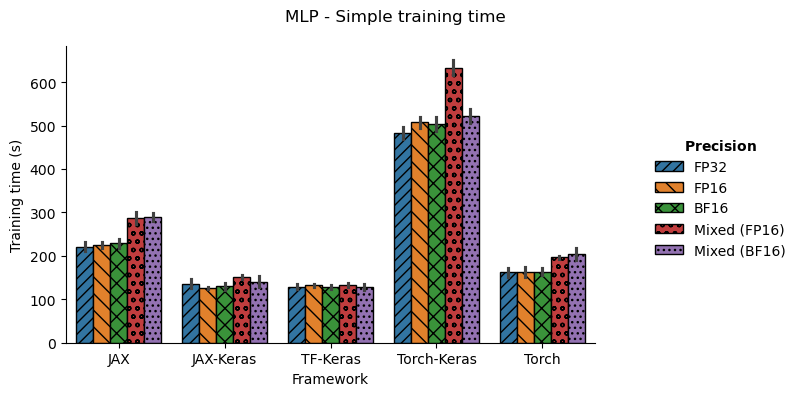

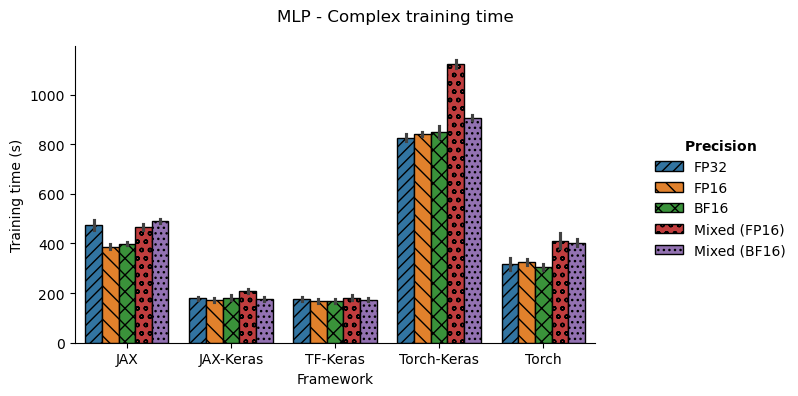

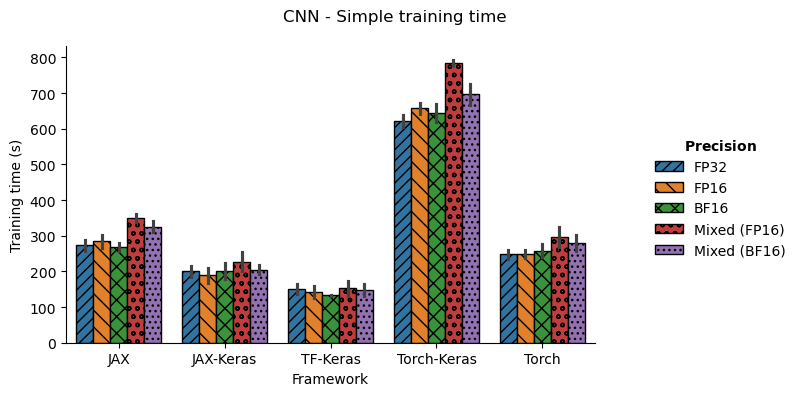

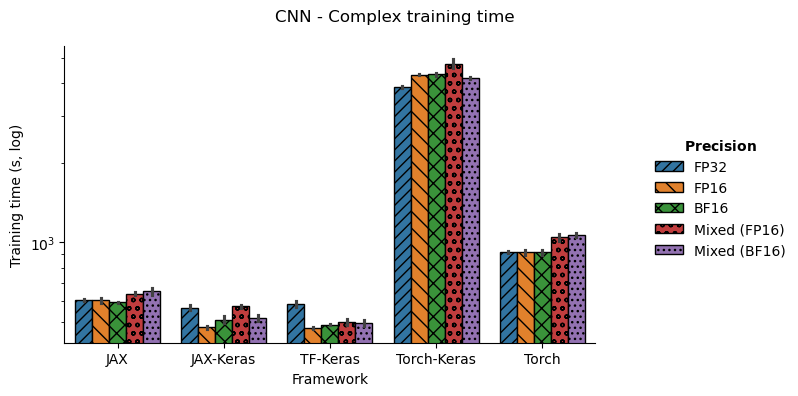

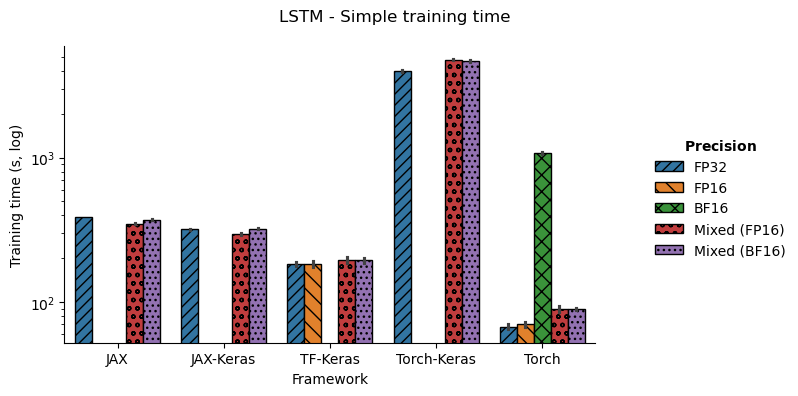

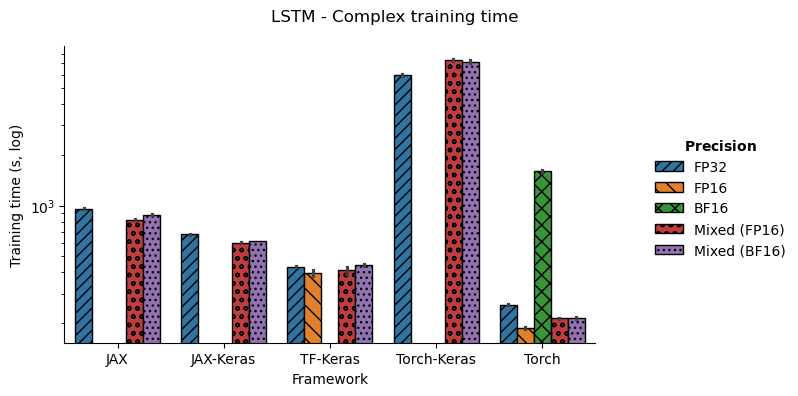

In [27]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plot_training_time(time_df, model, complexity, log=model=="lstm" or (model == "cnn" and complexity=="complex"))

In [28]:
base_df = time_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["training_time"]
    .mean()
    .reset_index()
)
ref = base_df["training_time"].min()
base_df["training_time_comp"] = 1 - (base_df["training_time"] / ref)
base_df = base_df.sort_values(by="training_time", ascending=True)
base_df.head()

backend model_type model_complexity  training_time  training_time_comp
2     tf-keras       lstm           simple     188.867605            0.000000
3        torch       lstm           simple     278.378556           -0.473935
1    jax-keras       lstm           simple     312.303404           -0.653557
0          jax       lstm           simple     369.136301           -0.954471
4  torch-keras       lstm           simple    4461.819035          -22.624057

In [29]:
base_df = time_df.query("model_type=='cnn' and model_complexity=='complex' and backend=='tf-keras'").copy()
base_df = (
    base_df.groupby("precision")["training_time"]
    .mean()
    .reset_index()
)
ref = base_df["training_time"].min()
base_df["training_time_comp"] = 1 - (base_df["training_time"] / ref)
base_df = base_df.sort_values(by="training_time", ascending=True)
base_df.head()

precision  training_time  training_time_comp
1        fp16     472.116387            0.000000
0        bf16     486.534671           -0.030540
3  mixed_bf16     495.329701           -0.049169
4  mixed_fp16     499.340071           -0.057663
2        fp32     582.810632           -0.234464

In [30]:
base_df = time_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-1])["training_time"]
    .mean()
    .reset_index()
)
base_df = (
    base_df.groupby(experiment_config[:-2])["training_time"]
    .agg(["min", "max"])
    .reset_index()
)
base_df = base_df.dropna(subset=["min", "max"])
base_df.head()

backend model_type model_complexity          min          max
0          jax       lstm           simple   348.138679   386.941550
1    jax-keras       lstm           simple   295.353024   322.560364
2     tf-keras       lstm           simple   182.821116   195.028161
3        torch       lstm           simple    67.290919  1075.719695
4  torch-keras       lstm           simple  3975.923307  4742.541535

In [31]:
base_df.query("backend=='torch-keras'")["min"].values[0] / base_df.query("backend=='torch'")["min"].values[0] - 1

np.float64(58.08558453791272)

In [32]:
base_df = time_df.query("model_type=='lstm' and model_complexity=='simple' ").copy()
base_df = base_df[~( (base_df["backend"] == "torch") & (base_df["precision"] == "bf16") )] # BF16 on Torch distorts the mean on LSTM
base_df = (
    base_df.groupby(experiment_config[:-2])["training_time"]
    .mean()
    .reset_index()
)
ref = base_df["training_time"].min()
base_df["training_time_comp"] = 1 - (base_df["training_time"] / ref)
base_df = base_df.sort_values(by="training_time", ascending=True)
base_df.head()

backend model_type model_complexity  training_time  training_time_comp
3        torch       lstm           simple      79.043271            0.000000
2     tf-keras       lstm           simple     188.867605           -1.389420
1    jax-keras       lstm           simple     312.303404           -2.951044
0          jax       lstm           simple     369.136301           -3.670053
4  torch-keras       lstm           simple    4461.819035          -55.447803

### Testing time

In [33]:
def plot_testing_time(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="testing_time",
        hue="precision",
        kind="bar",
        errorbar="sd",
        legend="auto"
    )
    
    add_patterns(plot)
    set_size(plot)

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    # Title
    add_title(plot, f"{model} - {complexity} testing time", adjust=0.95)
    plot.set_titles("{col_name}")

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Testing time (s, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Testing time (s)")
        
    format_legend_title(plot)
    #sns.move_legend(plot, "upper left", bbox_to_anchor=(0.08, 0.89), frameon=True)
    plot.tight_layout()

    save_plot(plot, f"{model}/testing_time{model}_{complexity}")

    return plot

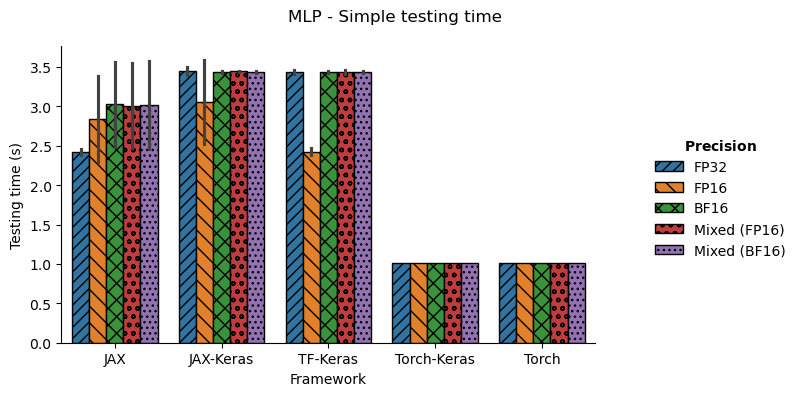

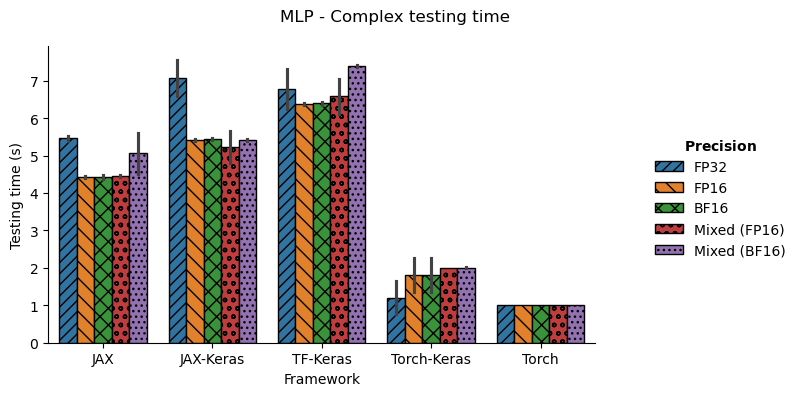

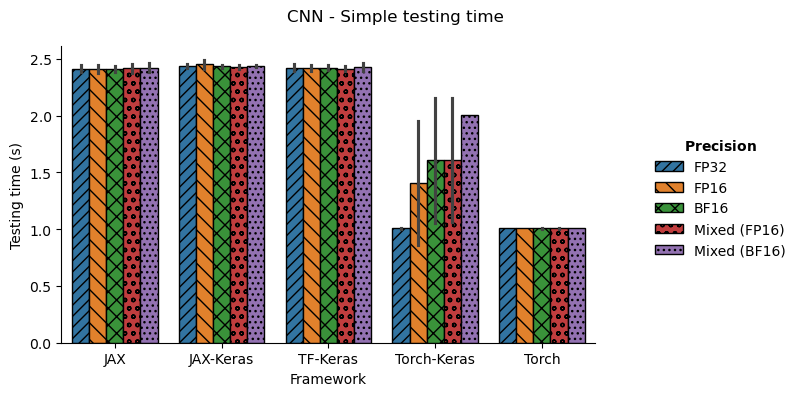

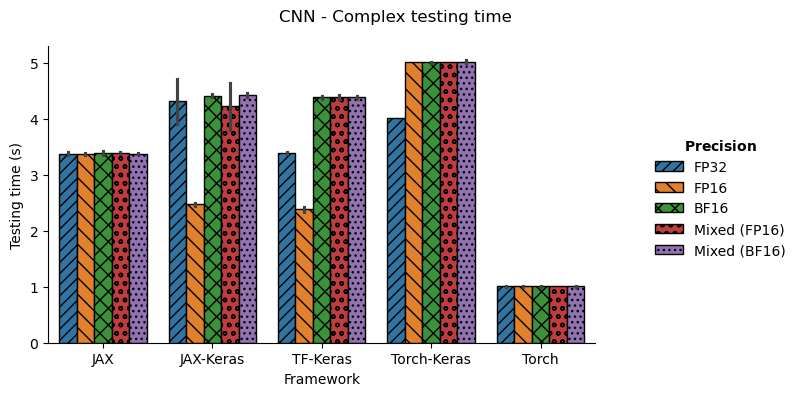

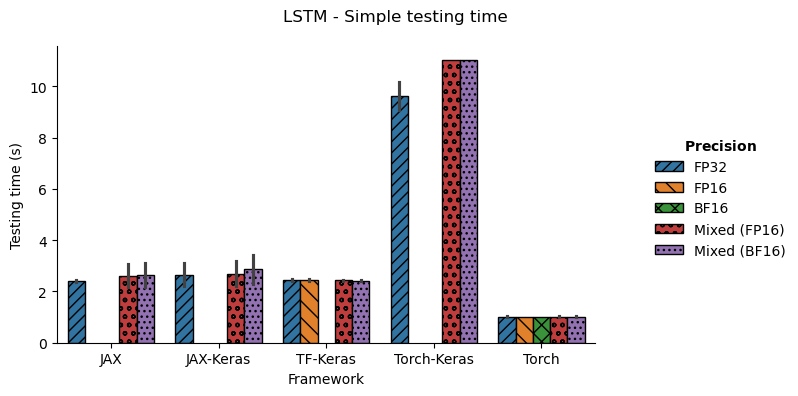

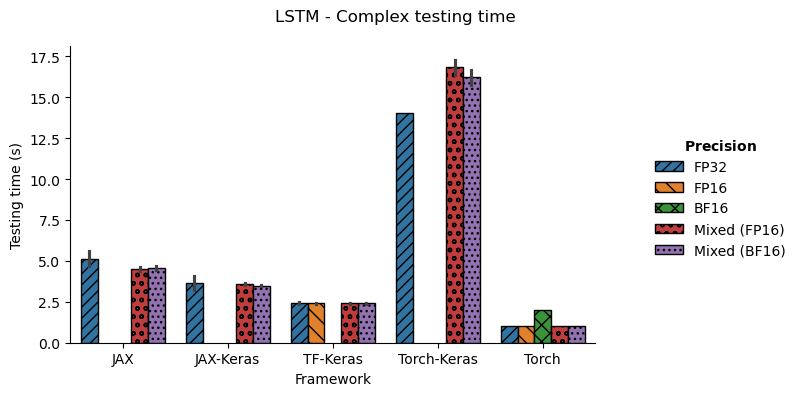

In [34]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plot_testing_time(time_df, model, complexity)

In [35]:
base_df = time_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["testing_time"]
    .mean()
    .reset_index()
)
ref = base_df["testing_time"].min()
base_df["testing_time_comp"] = (1 - (base_df["testing_time"] / ref))
base_df = base_df.sort_values(by="testing_time", ascending=True)
base_df.head()

backend model_type model_complexity  testing_time  testing_time_comp
3        torch       lstm           simple      1.012766           0.000000
2     tf-keras       lstm           simple      2.429949          -1.399319
0          jax       lstm           simple      2.558673          -1.526421
1    jax-keras       lstm           simple      2.736506          -1.702012
4  torch-keras       lstm           simple     10.551819          -9.418811

In [36]:
#1 - base_df.loc[27]["testing_time"] / base_df.loc[3]["testing_time"]

In [37]:
base_df = time_df.query("model_type=='lstm' and model_complexity=='complex' and backend=='jax'").copy()
base_df = (
    base_df.groupby("precision")["testing_time"]
    .mean()
    .reset_index()
)
ref = base_df["testing_time"].max()
base_df["testing_time_comp"] = 1 - (base_df["testing_time"] / ref)
base_df = base_df.sort_values(by="testing_time", ascending=True)
base_df.head()

precision  testing_time  testing_time_comp
2  mixed_fp16      4.508003           0.122300
1  mixed_bf16      4.551109           0.113907
0        fp32      5.136152           0.000000

## GPU metrics

In [38]:
def exp_config_category(df):
    # Convert experiment config columns to categorical, for better performance
    for col in experiment_config:
        order = orders[col]
        df[col] = pd.Categorical(
            df[col],
            categories=order,
            ordered=True
        )
    
    return df

In [39]:
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "train_samples"].groupby(experiment_config):
    backend, model, model_complexity, precision, seed = keys

    base_df = pd.read_csv(subset_df.iloc[0]["path"])

    base_df["backend"] = backend
    base_df["model_type"] = model
    base_df["model_complexity"] = model_complexity
    base_df["precision"] = precision
    base_df["seed"] = seed

    df_list.append(base_df)

train_samples_df = pd.concat(df_list, ignore_index=True)

# Reorder, add categories and sort by timestamp
train_samples_df = train_samples_df[experiment_config + train_samples_df.columns[:4].to_list()]
train_samples_df = exp_config_category(train_samples_df)
train_samples_df = train_samples_df.sort_values(by=experiment_config).reset_index(drop=True)

train_samples_df.head()

backend model_type model_complexity precision seed  timestamp  \
0     jax        mlp           simple      fp32   42   2.190392   
1     jax        mlp           simple      fp32   42   3.191456   
2     jax        mlp           simple      fp32   42   4.192263   
3     jax        mlp           simple      fp32   42   5.193223   
4     jax        mlp           simple      fp32   42   6.194193   

   gpu_2_utilization  gpu_2_memory_used  gpu_2_power  
0                  0         62065.1875       64.923  
1                  0         62075.1875       63.950  
2                  9         62075.1875       65.681  
3                  0         62075.1875       64.644  
4                  0         62075.1875       64.436

### GPU utilisation

In [40]:
def plot_utilisation_time(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="gpu_2_utilization",
        hue="precision",
        kind="bar",
        errorbar="sd",
        legend="auto"
    )
    
    add_patterns(plot)
    set_size(plot)

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    # Title
    add_title(plot, f"{model} - {complexity} mean GPU utilisation", adjust=0.95)
    plot.set_titles("{col_name}")

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "GPU Utilisation (%, log)")
    else:
        plot.set_axis_labels(titles["backend"], "GPU Utilisation (%)")
        
    format_legend_title(plot)
    #sns.move_legend(plot, "upper left", bbox_to_anchor=(0.08, 0.89), frameon=True)
    plot.tight_layout()

    #save_plot(plot, f"{model}/utilisation_bars_{model}_{complexity}")

    return plot

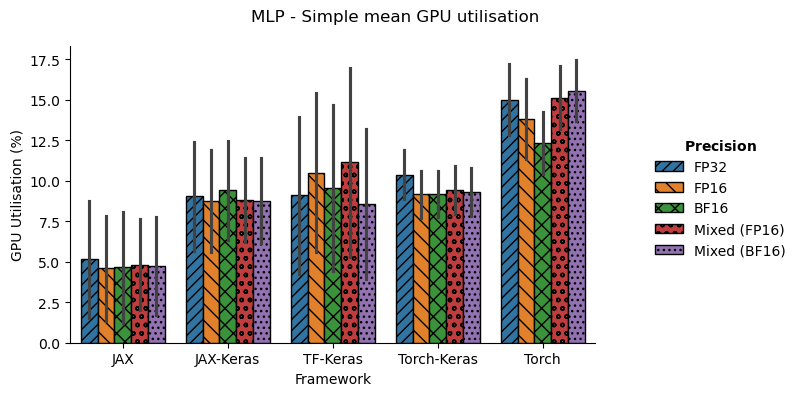

In [41]:
plot_utilisation_time(train_samples_df, "mlp", "simple")

In [42]:
def plot_utilisation_heatmap(df, model, complexity):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = plot_df.groupby(experiment_config[:-1])["gpu_2_utilization"].mean().reset_index()
    plot_df = add_labels(plot_df)

    plot_df = plot_df.pivot_table(
        index="precision", columns="backend", values="gpu_2_utilization"
    )

    plot = sns.heatmap(
        plot_df,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        cbar_kws={"label": "GPU usage (%)"}
    )
    
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    add_title(plot, f"{model} - {complexity} mean GPU usage", adjust=0.92)
    plot.set_xlabel(titles["backend"])
    plot.set_ylabel(titles["precision"])

    save_plot(plot, f"{model}/usage_heatmap_{model}_{complexity}")

    return plot

/tmp/ipykernel_245412/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_245412/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_245412/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_245412/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plot.figure.subplots_adjust(top=adjust)
/tmp/ipykernel_245412/874083804.py:3: UserWarning: This figure was using a layout engine that is incompatibl

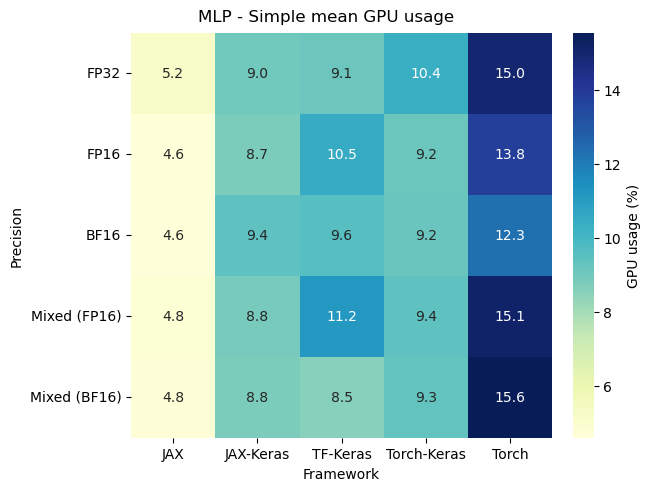

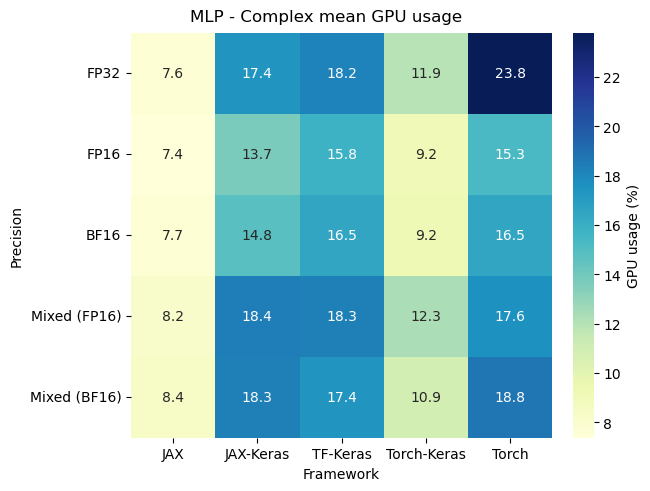

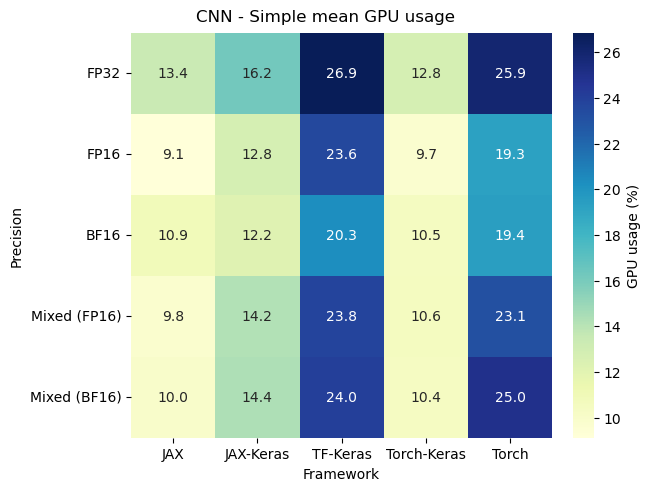

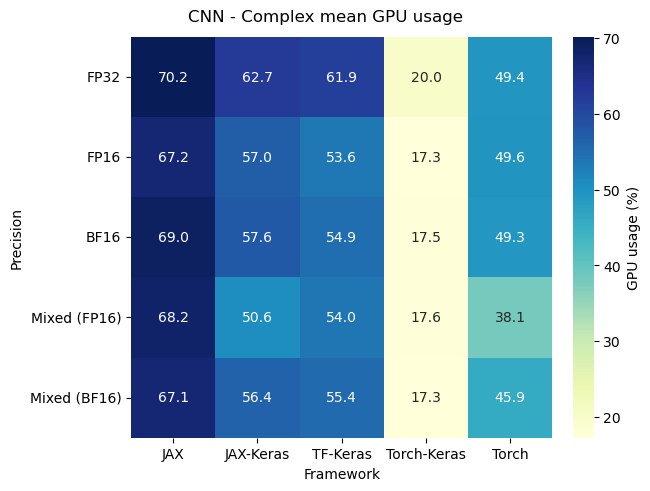

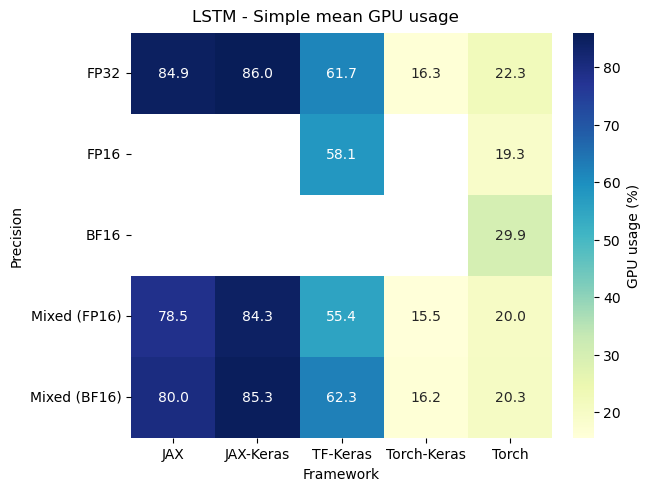

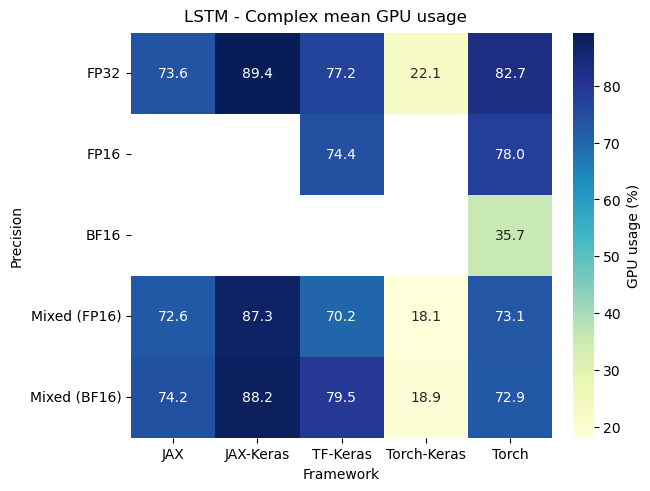

In [43]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plt.figure(constrained_layout=True)
        plot = plot_utilisation_heatmap(train_samples_df, model, complexity)

In [44]:
base_df = train_samples_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["gpu_2_utilization"]
    .mean()
    .reset_index()
)
ref = base_df["gpu_2_utilization"].max()
base_df["comp"] = 1 - (base_df["gpu_2_utilization"] / ref)
base_df = base_df.sort_values(by="gpu_2_utilization", ascending=True)
base_df.head()

backend model_type model_complexity  gpu_2_utilization      comp
22  torch-keras       lstm           simple          15.982825  0.812489
28        torch       lstm           simple          27.761651  0.674300
16     tf-keras       lstm           simple          59.356087  0.303634
4           jax       lstm           simple          81.247478  0.046803
10    jax-keras       lstm           simple          85.236853  0.000000

In [45]:
base_df = train_samples_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = base_df[~( (base_df["backend"] == "torch") & (base_df["precision"] == "bf16") )] # BF16 distorts the mean on LSTM
base_df = (
    base_df.groupby(experiment_config[:-2])["gpu_2_utilization"]
    .mean()
    .reset_index()
)
ref = base_df["gpu_2_utilization"].max()
base_df["comp"] = 1 - (base_df["gpu_2_utilization"] / ref)
base_df = base_df.sort_values(by="gpu_2_utilization", ascending=True)
base_df.head()

backend model_type model_complexity  gpu_2_utilization      comp
22  torch-keras       lstm           simple          15.982825  0.812489
28        torch       lstm           simple          20.408486  0.760567
16     tf-keras       lstm           simple          59.356087  0.303634
4           jax       lstm           simple          81.247478  0.046803
10    jax-keras       lstm           simple          85.236853  0.000000

In [46]:
85.236853 / 81.247478

1.0491015241113084

### GPU memory

In [47]:
memory_df = train_samples_df.groupby(experiment_config[:-1])["gpu_2_memory_used"].max().reset_index()
memory_df["max_memory"] = memory_df["gpu_2_memory_used"] / 1024  # Convert to GB
memory_df = memory_df.drop("gpu_2_memory_used", axis=1)
memory_df.head(10)

backend model_type model_complexity   precision  max_memory
0     jax        mlp           simple        fp32   60.622253
1     jax        mlp           simple        fp16   60.630066
2     jax        mlp           simple        bf16   60.630066
3     jax        mlp           simple  mixed_fp16   60.630066
4     jax        mlp           simple  mixed_bf16   60.630066
5     jax        mlp          complex        fp32   60.622253
6     jax        mlp          complex        fp16   60.632019
7     jax        mlp          complex        bf16   60.632019
8     jax        mlp          complex  mixed_fp16   60.632019
9     jax        mlp          complex  mixed_bf16   60.632019

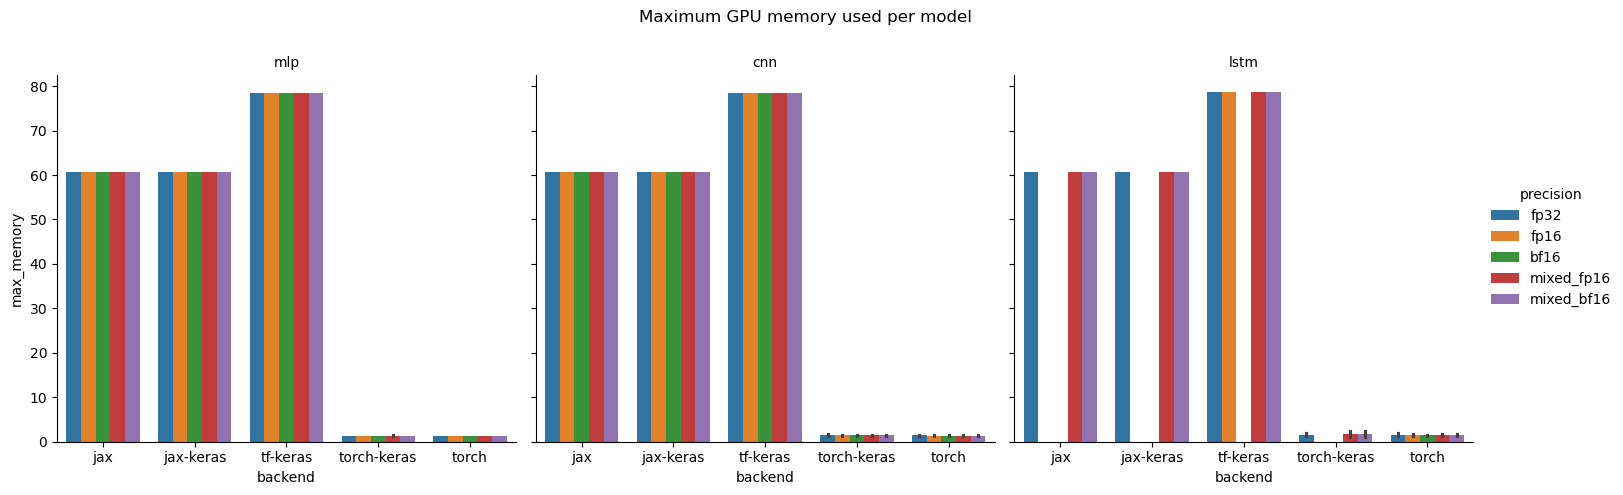

In [48]:
plot = sns.catplot(
    data=memory_df,
    x="backend",
    y="max_memory",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Maximum GPU memory used per model")

plot.set_titles(col_template="{col_name}")

In [49]:
memory_df = memory_df.groupby(["backend"])["max_memory"].max().sort_values(ascending=False).reset_index()
memory_df.head()

backend  max_memory
0     tf-keras   78.569519
1    jax-keras   60.716003
2          jax   60.712097
3  torch-keras    2.216003
4        torch    1.815613

In [50]:
base_df = memory_df.copy()
ref = base_df["max_memory"].max()
base_df["comp"] = (base_df["max_memory"] / ref)
base_df = base_df.sort_values(by="max_memory", ascending=True)
base_df.head()

backend  max_memory      comp
4        torch    1.815613  0.023108
3  torch-keras    2.216003  0.028204
2          jax   60.712097  0.772718
1    jax-keras   60.716003  0.772768
0     tf-keras   78.569519  1.000000

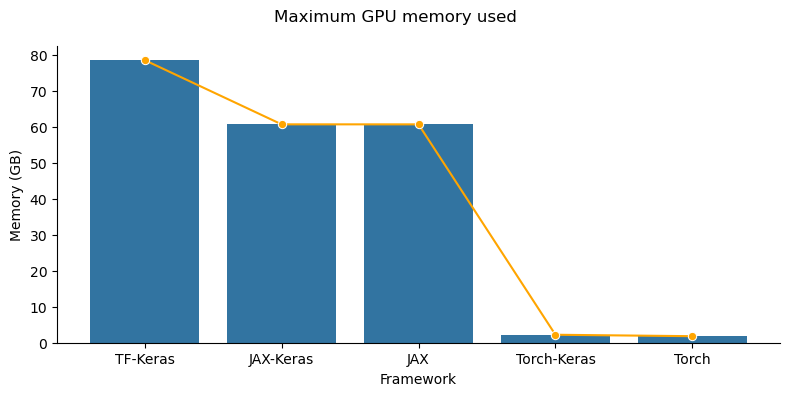

In [51]:
base_df = add_labels(memory_df)

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="max_memory",
    kind="bar",
    errorbar="sd",
    order=base_df["backend"]
)

sns.lineplot(
    x=base_df["backend"],
    y=base_df["max_memory"],
    ax=plot.ax,
    marker="o",
    color="orange"
)

set_size(plot)

add_title(plot, "Maximum GPU memory used")
plot.set_axis_labels(titles["backend"], "Memory (GB)")

plt.tight_layout()

save_plot(plot, "memory_bars")

### GPU Power

In [52]:
energy_df = train_samples_df[experiment_config + ["timestamp", "gpu_2_power"]]

energy_df = energy_df.sort_values(by=experiment_config + ["timestamp"]).reset_index(drop=True)
energy_df.head()

backend model_type model_complexity precision seed  timestamp  gpu_2_power
0     jax        mlp           simple      fp32   42   2.190392       64.923
1     jax        mlp           simple      fp32   42   3.191456       63.950
2     jax        mlp           simple      fp32   42   4.192263       65.681
3     jax        mlp           simple      fp32   42   5.193223       64.644
4     jax        mlp           simple      fp32   42   6.194193       64.436

### GPU Energy Consumption

In [53]:
# Energy (J) = Power (W) * time (s)
energy_df["dt"] = energy_df.groupby(experiment_config)["timestamp"].diff().fillna(0)

energy_df["energy"] = energy_df["gpu_2_power"] * energy_df["dt"]
energy_df["cum_energy"] = energy_df.groupby(experiment_config)["energy"].cumsum()

energy_df.head()

backend model_type model_complexity precision seed  timestamp  gpu_2_power  \
0     jax        mlp           simple      fp32   42   2.190392       64.923   
1     jax        mlp           simple      fp32   42   3.191456       63.950   
2     jax        mlp           simple      fp32   42   4.192263       65.681   
3     jax        mlp           simple      fp32   42   5.193223       64.644   
4     jax        mlp           simple      fp32   42   6.194193       64.436   

         dt     energy  cum_energy  
0  0.000000   0.000000    0.000000  
1  1.001064  64.018032   64.018032  
2  1.000807  65.734008  129.752039  
3  1.000959  64.706019  194.458058  
4  1.000970  64.498511  258.956569

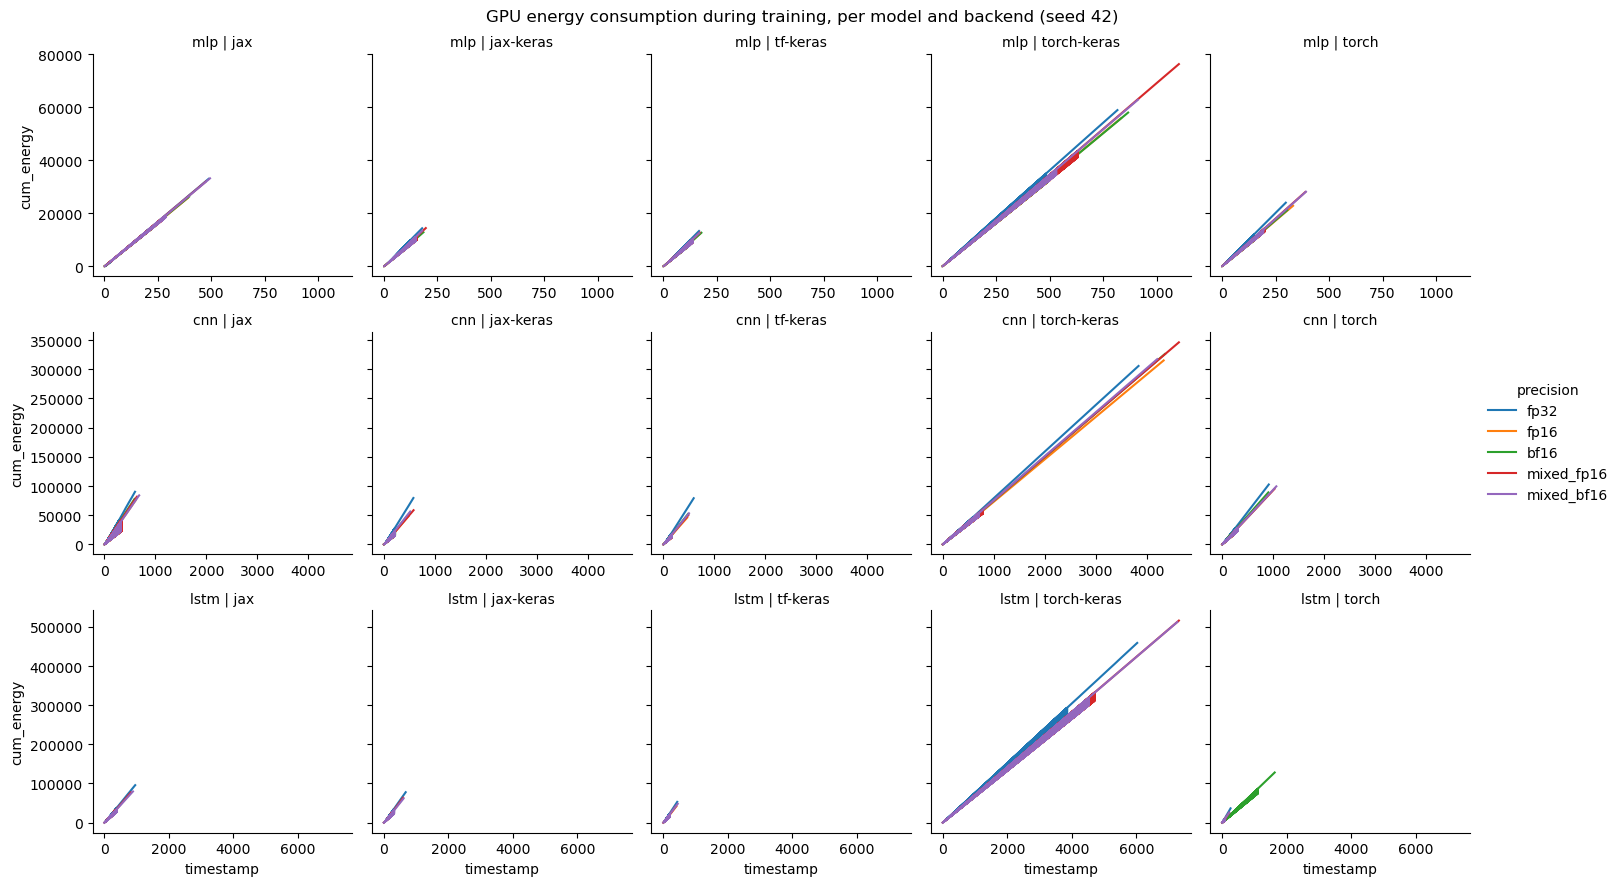

In [56]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="cum_energy",
    kind="line",
    hue="precision",
    col="backend",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": "row"},
    height=3
)

add_title(plot, "GPU energy consumption during training, per model and backend (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")


In [57]:

total_energy_df = (
    energy_df
    .groupby(experiment_config)["cum_energy"]
    .last()
    .reset_index()
    .rename(columns={"cum_energy": "energy"})
)

total_energy_df["energy"] = total_energy_df["energy"] / 1000 # kJ

total_energy_df.head()

backend model_type model_complexity precision seed     energy
0     jax        mlp           simple      fp32   42  13.898514
1     jax        mlp           simple      fp32   43  15.192393
2     jax        mlp           simple      fp32   44  14.993291
3     jax        mlp           simple      fp32   45  13.665134
4     jax        mlp           simple      fp32   46  14.149745

In [58]:
def plot_total_energy(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="energy",
        hue="precision",
        kind="bar",
        errorbar="sd",
        legend="auto"
    )
    
    add_patterns(plot)
    set_size(plot)
    
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    add_title(plot, f"{model} - {complexity} total energy consumption during training")
    format_legend_title(plot)

    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Energy (kJ, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Energy (kJ)")

    save_plot(plot, f"{model}/total_energy_bars_{model}_{complexity}")

<Figure size 640x480 with 0 Axes>

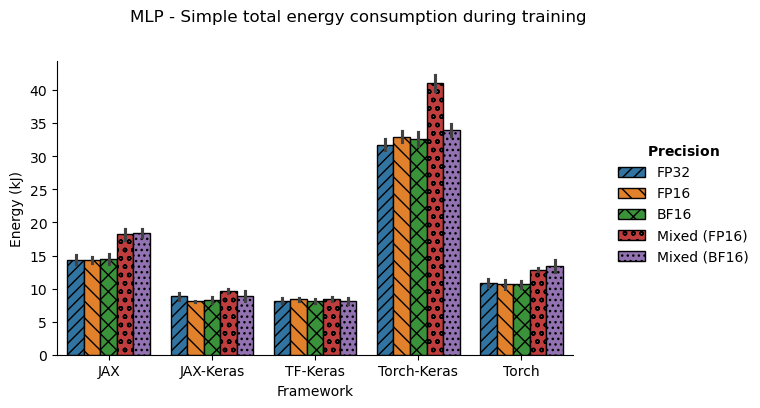

<Figure size 640x480 with 0 Axes>

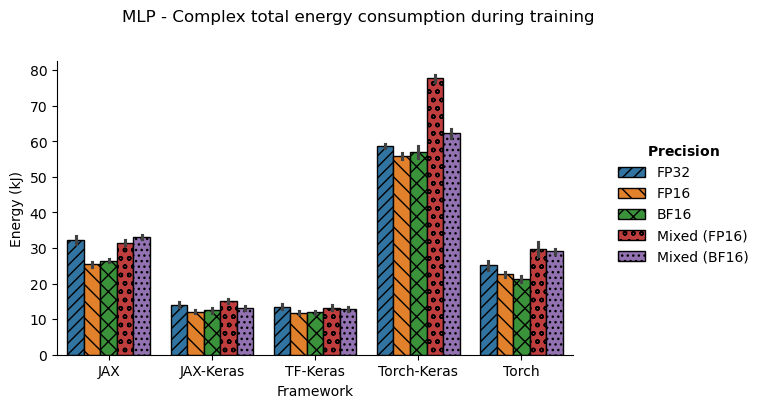

<Figure size 640x480 with 0 Axes>

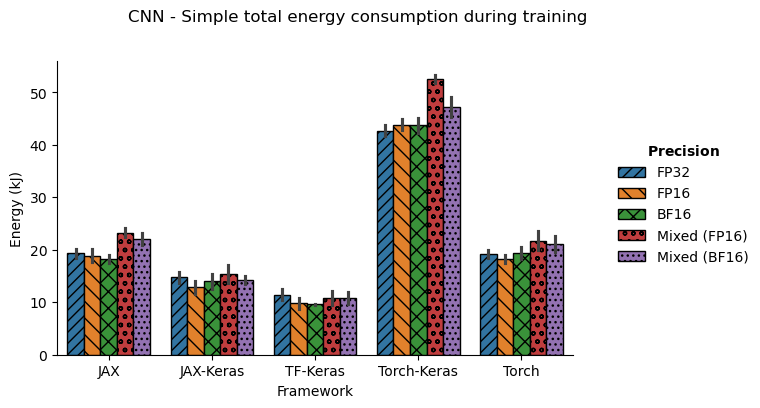

<Figure size 640x480 with 0 Axes>

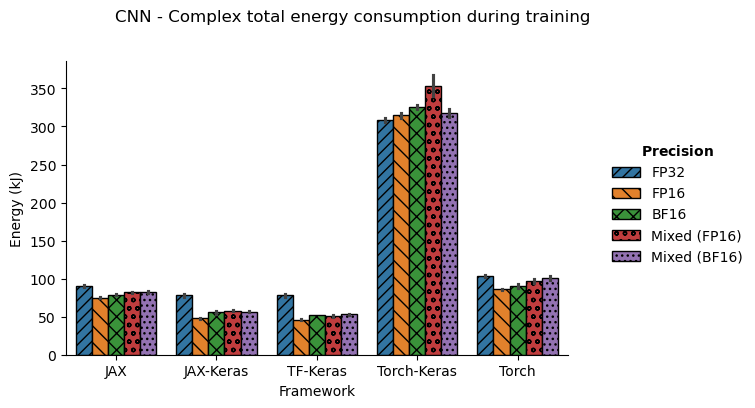

<Figure size 640x480 with 0 Axes>

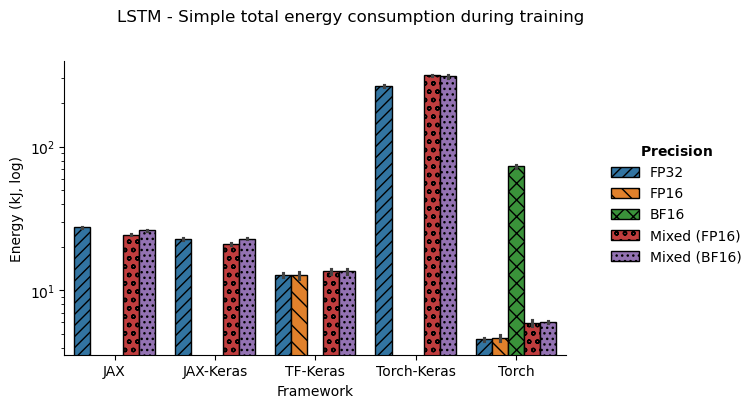

<Figure size 640x480 with 0 Axes>

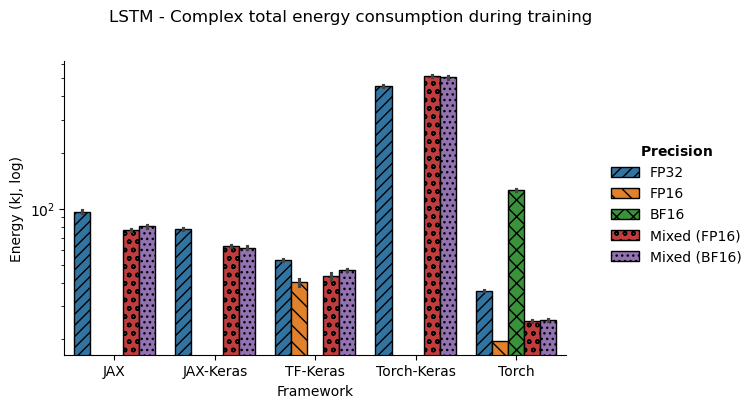

In [59]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plt.figure()
        plot_total_energy(total_energy_df, model, complexity, log=model=="lstm")

In [60]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["energy"]
    .mean()
    .reset_index()
)
ref = base_df["energy"].min()
base_df["energy_comp"] = 1 - (base_df["energy"] / ref)
base_df = base_df.sort_values(by="energy", ascending=True)
base_df.head()

backend model_type model_complexity      energy  energy_comp
16     tf-keras       lstm           simple   13.166689     0.000000
28        torch       lstm           simple   18.798477    -0.427730
10    jax-keras       lstm           simple   22.200899    -0.686141
4           jax       lstm           simple   25.985661    -0.973591
22  torch-keras       lstm           simple  295.464240   -21.440284

In [61]:
base_df = total_energy_df.copy()
base_df["mixed"] = base_df["precision"].str.contains("mixed")
base_df = base_df[base_df["energy"] > 0]
base_df = (
    base_df.groupby(experiment_config[:-2] + ["mixed"])["energy"]
    .mean()
    .reset_index()
)
base_df = base_df.pivot_table(
    index=experiment_config[:-2], 
    columns="mixed", 
    values="energy"
).reset_index()

base_df = base_df.rename(columns={False: "energy_no_mixed", True: "energy_mixed"})
base_df["comp"] = base_df["energy_mixed"] / base_df["energy_no_mixed"]

print(f"Result: {(base_df['comp'].mean() - 1) * 100}")

Result: 1.9742369586663866


In [62]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = base_df[~( (base_df["backend"] == "torch") & (base_df["precision"] == "bf16") )] # BF16 distorts the mean on LSTM
base_df = (
    base_df.groupby(experiment_config[:-2])["energy"]
    .mean()
    .reset_index()
)
ref = base_df["energy"].min()
base_df["energy_comp"] = 1 - (base_df["energy"] / ref)
base_df = base_df.sort_values(by="energy", ascending=True)
base_df.head()

backend model_type model_complexity      energy  energy_comp
28        torch       lstm           simple    5.289004     0.000000
16     tf-keras       lstm           simple   13.166689    -1.489446
10    jax-keras       lstm           simple   22.200899    -3.197557
4           jax       lstm           simple   25.985661    -3.913148
22  torch-keras       lstm           simple  295.464240   -54.863870

In [63]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-1])["energy"]
    .mean()
    .reset_index()
)

base_df = base_df[ base_df["precision"].isin( ["fp32", "mixed_fp16", "mixed_bf16"] ) ]
base_df["mixed"] = base_df["precision"].str.contains("mixed")

base_df = base_df[base_df["energy"] > 0]

base_df = (
    base_df.groupby(["backend", "mixed"])["energy"]
    .mean()
    .reset_index()
)

base_df = base_df.pivot_table(
    index=["backend"], 
    columns="mixed", 
    values="energy"
).reset_index()

base_df = base_df.rename(columns={False: "energy_fp32", True: "energy_mixed"})
base_df["comp"] = 1 - base_df["energy_mixed"] / base_df["energy_fp32"]

#print(f"Result: {(base_df['comp'].mean() - 1) * 100}")
res = (base_df[base_df['backend'] != 'torch-keras']['comp'].mean()) * 100
print(f"Mixed over FP32 mean improvement (all but torch-keras): {res:.1f}%")

tk_row = base_df[base_df['backend'] == 'torch-keras']
res = (1 - tk_row["energy_fp32"].iloc[0] / tk_row["energy_mixed"].iloc[0]) * 100
print(f"torch-keras FP32 over mixed improvement: {res:.1f}%")

base_df = base_df.sort_values(by="comp", ascending=True)
base_df.head()

Mixed over FP32 mean improvement (all but torch-keras): -6.5%
torch-keras FP32 over mixed improvement: 15.7%


mixed      backend  energy_fp32  energy_mixed      comp
4            torch     4.556453      5.973527 -0.311004
3      torch-keras   262.847580    311.772570 -0.186134
2         tf-keras    12.743818     13.601813 -0.067326
1        jax-keras    22.819508     21.891594  0.040663
0              jax    27.435220     25.260881  0.079254

In [64]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-1])["energy"]
    .mean()
    .reset_index()
)
base_df = (
    base_df.groupby(experiment_config[:-2])["energy"]
    .agg(["min", "max"])
    .reset_index()
)
base_df = base_df.dropna(subset=["min", "max"])
base_df.head()

backend model_type model_complexity         min         max
4           jax       lstm           simple   24.375072   27.435220
10    jax-keras       lstm           simple   20.932065   22.851124
16     tf-keras       lstm           simple   12.719313   13.601905
22  torch-keras       lstm           simple  262.847580  314.394747
28        torch       lstm           simple    4.556453   72.836370

In [65]:
base_df.query("backend=='torch-keras'")["min"].values[0] / base_df.query("backend=='torch'")["min"].values[0] - 1

np.float64(56.68688759389007)

### GPU Energy per Hour

In [66]:
time_df = exp_config_category(time_df)
time_df.head()

backend model_type model_complexity precision seed  training_time  \
0     jax        cnn          complex      bf16   42     593.557829   
1     jax        cnn          complex      bf16   43     588.882573   
2     jax        cnn          complex      bf16   44     586.818991   
3     jax        cnn          complex      bf16   45     591.476808   
4     jax        cnn          complex      bf16   46     592.265013   

   testing_time  
0      3.350694  
1      3.386329  
2      3.384836  
3      3.430464  
4      3.401185

In [67]:
total_energy_df = pd.merge(
    total_energy_df,
    time_df[experiment_config + ["training_time"]],
    on=experiment_config,
    how="left"
)

total_energy_df["energy_per_hour"] = total_energy_df["energy"] / (total_energy_df["training_time"] / 3600)

total_energy_df.head()

backend model_type model_complexity precision seed     energy  \
0     jax        mlp           simple      fp32   42  13.898514   
1     jax        mlp           simple      fp32   43  15.192393   
2     jax        mlp           simple      fp32   44  14.993291   
3     jax        mlp           simple      fp32   45  13.665134   
4     jax        mlp           simple      fp32   46  14.149745   

   training_time  energy_per_hour  
0     218.031574       229.483503  
1     234.050772       233.678420  
2     229.041067       235.660130  
3     204.951069       240.030375  
4     220.036557       231.502813

In [68]:
def plot_energy_hour(df, model, complexity, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    plot = sns.catplot(
        data=plot_df,
        x="backend",
        y="energy_per_hour",
        hue="precision",
        kind="bar",
        errorbar="sd",
        legend="auto"
    )
    
    add_patterns(plot)
    set_size(plot)

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    add_title(plot, f"{model} - {complexity} energy consumption per training hour", 0.92)
    format_legend_title(plot)
    plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")
    
    if log:
        plot.set(yscale="log")
        plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h, log)")
    else:
        plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")

    save_plot(plot, f"{model}/energy_per_hour_bars_{model}_{complexity}")

<Figure size 640x480 with 0 Axes>

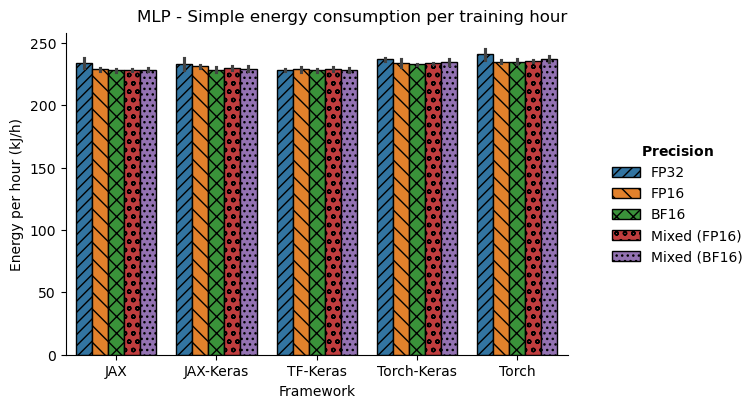

<Figure size 640x480 with 0 Axes>

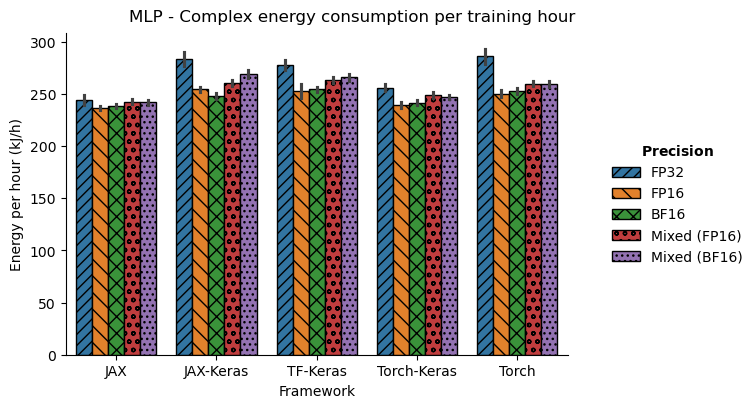

<Figure size 640x480 with 0 Axes>

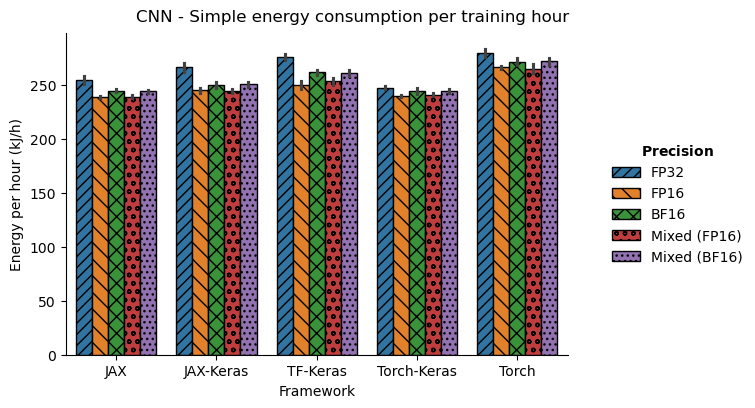

<Figure size 640x480 with 0 Axes>

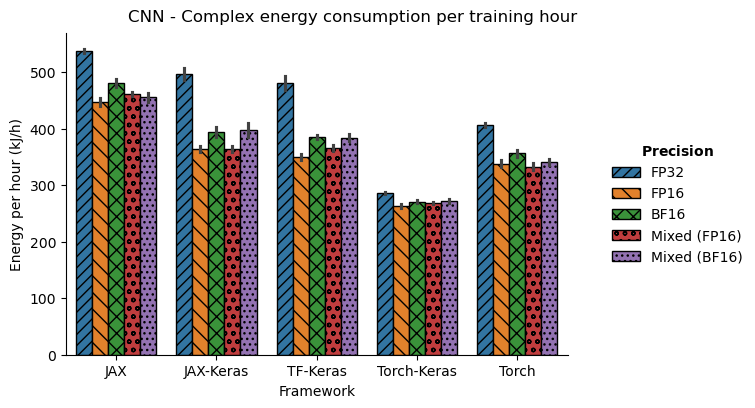

<Figure size 640x480 with 0 Axes>

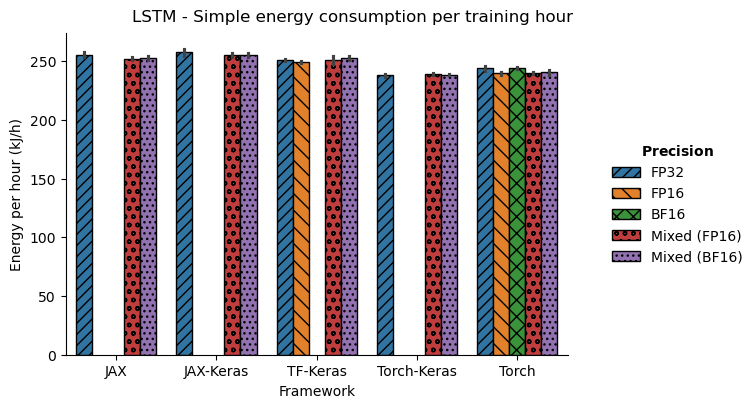

<Figure size 640x480 with 0 Axes>

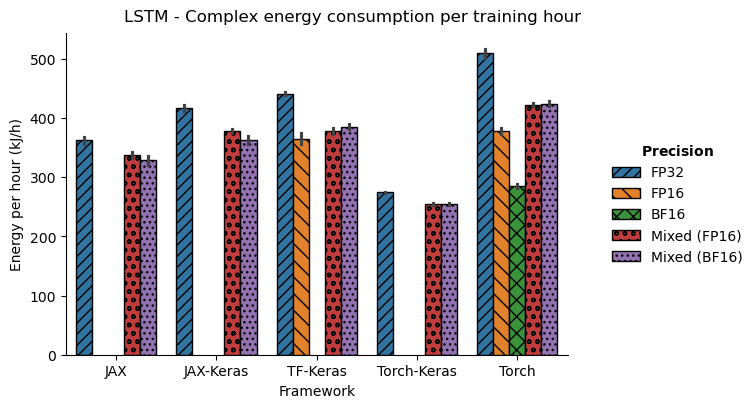

In [69]:
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plt.figure()
        plot_energy_hour(total_energy_df, model, complexity)

In [70]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["energy_per_hour"]
    .mean()
    .reset_index()
)
ref = base_df["energy_per_hour"].min()
base_df["energy_comp"] = 1 - (base_df["energy_per_hour"] / ref)
base_df = base_df.sort_values(by="energy_per_hour", ascending=True)
base_df.head()

backend model_type model_complexity  energy_per_hour  energy_comp
22  torch-keras       lstm           simple       238.380497     0.000000
28        torch       lstm           simple       241.566310    -0.013364
16     tf-keras       lstm           simple       250.940643    -0.052689
4           jax       lstm           simple       253.371470    -0.062887
10    jax-keras       lstm           simple       255.901690    -0.073501

In [71]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[1:-1])["energy_per_hour"]
    .mean()
    .reset_index()
)
ref = base_df["energy_per_hour"].min()
base_df["energy_comp"] = 1 - (base_df["energy_per_hour"] / ref)
base_df = base_df.sort_values(by="energy_per_hour", ascending=True)
base_df.head()

model_type model_complexity   precision  energy_per_hour  energy_comp
22       lstm           simple        bf16       243.753130     0.000000
21       lstm           simple        fp16       244.515965    -0.003130
23       lstm           simple  mixed_fp16       247.387650    -0.014911
24       lstm           simple  mixed_bf16       247.851565    -0.016814
20       lstm           simple        fp32       249.114791    -0.021996

In [72]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = base_df[~( (base_df["backend"] == "torch") & (base_df["precision"] == "bf16") )] # BF16 distorts the mean on LSTM
base_df = (
    base_df.groupby(experiment_config[:-2])["energy_per_hour"]
    .mean()
    .reset_index()
)
ref = base_df["energy_per_hour"].min()
base_df["energy_comp"] = 1 - (base_df["energy_per_hour"] / ref)
base_df = base_df.sort_values(by="energy_per_hour", ascending=True)
base_df.head()

backend model_type model_complexity  energy_per_hour  energy_comp
22  torch-keras       lstm           simple       238.380497     0.000000
28        torch       lstm           simple       241.019605    -0.011071
16     tf-keras       lstm           simple       250.940643    -0.052689
4           jax       lstm           simple       253.371470    -0.062887
10    jax-keras       lstm           simple       255.901690    -0.073501

In [73]:
base_df = total_energy_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-1])["energy_per_hour"]
    .mean()
    .reset_index()
)

base_df = base_df[ base_df["precision"].isin( ["fp32", "mixed_fp16", "mixed_bf16"] ) ]
base_df["mixed"] = base_df["precision"].str.contains("mixed")

base_df = base_df[base_df["energy_per_hour"] > 0]

base_df = (
    base_df.groupby(["backend", "mixed"])["energy_per_hour"]
    .mean()
    .reset_index()
)

base_df = base_df.pivot_table(
    index=["backend"], 
    columns="mixed", 
    values="energy_per_hour"
).reset_index()

base_df = base_df.rename(columns={False: "energy_fp32", True: "energy_mixed"})
base_df["comp"] = 1 - base_df["energy_mixed"] / base_df["energy_fp32"]

#print(f"Result: {(base_df['comp'].mean() - 1) * 100}")
res = (base_df['comp'].mean()) * 100
print(f"Mixed over FP32 mean improvement: {res:.1f}%")

base_df = base_df.sort_values(by="comp", ascending=True)
base_df.head()

Mixed over FP32 mean improvement: 0.6%


mixed      backend  energy_fp32  energy_mixed      comp
2         tf-keras   250.954850    251.732305 -0.003098
3      torch-keras   238.013483    238.564003 -0.002313
1        jax-keras   257.527629    255.088721  0.009470
0              jax   255.249070    252.432670  0.011034
4            torch   243.828922    240.280340  0.014554

In [74]:
total_energy_df.groupby(["backend", "model_type", "model_complexity"])["energy_per_hour"].mean().reset_index().query("model_type == 'lstm'")

backend model_type model_complexity  energy_per_hour
4           jax       lstm           simple       253.371470
5           jax       lstm          complex       342.915759
10    jax-keras       lstm           simple       255.901690
11    jax-keras       lstm          complex       386.255318
16     tf-keras       lstm           simple       250.940643
17     tf-keras       lstm          complex       392.602868
22  torch-keras       lstm           simple       238.380497
23  torch-keras       lstm          complex       261.042759
28        torch       lstm           simple       241.566310
29        torch       lstm          complex       403.755524

#### Overall comparison

In [75]:
energy_sum_df = (
    total_energy_df
    .groupby(["backend"])
    .agg(
        total_energy=("energy", "sum"),
        total_time=("training_time", "sum")
    )
    .reset_index()
)

energy_sum_df["global_energy_per_hour"] = energy_sum_df["total_energy"] / (energy_sum_df["total_time"] / 3600)
energy_sum_df = energy_sum_df.sort_values(by="global_energy_per_hour", ascending=False)

max_value = energy_sum_df["global_energy_per_hour"].max()
energy_sum_df["improvement"] = 1 - energy_sum_df["global_energy_per_hour"] / max_value

energy_sum_df.head()

backend  total_energy     total_time  global_energy_per_hour  \
2     tf-keras   3366.755421   36105.975661              335.687356   
1    jax-keras   3739.313758   40406.486828              333.152684   
0          jax   5353.439417   59163.203144              325.749467   
4        torch   5449.586916   63471.666646              309.090874   
3  torch-keras  23486.335544  329336.223532              256.730969   

   improvement  
2     0.000000  
1     0.007551  
0     0.029605  
4     0.079230  
3     0.235208

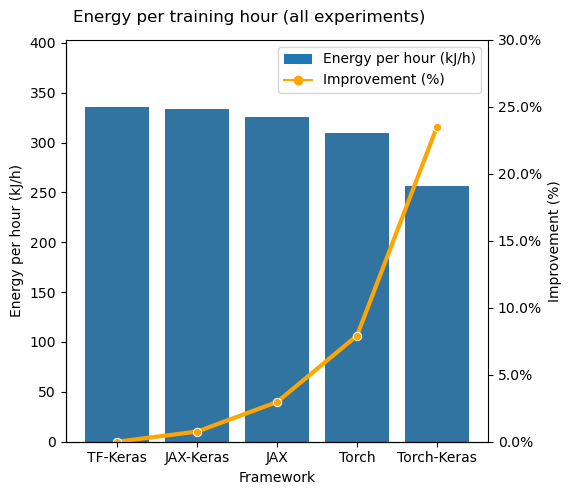

In [76]:
base_df = add_labels(energy_sum_df)

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="global_energy_per_hour",
    kind="bar",
    errorbar="sd",
    order=base_df["backend"]
)

ax = plot.ax
ax.set_ylabel("Energy per hour (kJ/h)")
ax.set_ylim(0, max_value * 1.2)

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylabel("Improvement (%)")
ax2.set_ylim(0, 0.3)

sns.lineplot(
    data=base_df,
    x="backend",
    y="improvement",
    ax=ax2,
    marker="o",
    color="orange",
    linewidth=3
)

add_title(plot, "Energy per training hour (all experiments)", adjust=0.92)
plot.set_titles(col_template="{col_name}")
plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")


legend_elements = [
    Patch(label="Energy per hour (kJ/h)"),
    Line2D([0], [0], color="orange", marker="o", label="Improvement (%)"),
]

ax.legend(handles=legend_elements, loc="best")

#save_plot(plot, "energy_per_hour_all")


## Test results

### Experiment status

In [77]:
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "test"].groupby(experiment_config):
    backend, model, model_complexity, precision, seed = keys

    base_df = pd.read_csv(subset_df.iloc[0]["path"])

    base_df["backend"] = backend
    base_df["model_type"] = model
    base_df["model_complexity"] = model_complexity
    base_df["precision"] = precision
    base_df["seed"] = seed

    df_list.append(base_df)

test_df = pd.concat(df_list, ignore_index=True)
test_df = exp_config_category(test_df)

test_df = test_df[experiment_config + ["time", "loss", "metric"]]
test_df = test_df.sort_values(by=experiment_config).reset_index(drop=True)

test_df.head()

backend model_type model_complexity precision seed      time      loss  \
0     jax        mlp           simple      fp32   42  2.446716  0.282897   
1     jax        mlp           simple      fp32   43  2.461142  0.284469   
2     jax        mlp           simple      fp32   44  2.439721  0.287033   
3     jax        mlp           simple      fp32   45  2.365834  0.281953   
4     jax        mlp           simple      fp32   46  2.410749  0.279295   

     metric  
0  0.898985  
1  0.900876  
2  0.895999  
3  0.897293  
4  0.900478

In [78]:
failed_df: pd.DataFrame = (
    test_df.groupby(experiment_config)
    .apply(lambda g: g[["loss", "metric"]].isna().values.any())
    .reset_index(name="failed")
)

# Add experiments with errors
error_df["error"] = True

failed_df = failed_df.merge(
    error_df[experiment_config + ["error"]],
    on=experiment_config,
    how="outer"
)

failed_df["failed"] = failed_df["failed"].fillna(False)
failed_df["error"] = failed_df["error"].fillna(False)

failed_df.head()

/tmp/ipykernel_245412/3708063559.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df.groupby(experiment_config)


backend model_type model_complexity precision seed  failed  error
0     jax        cnn          complex      bf16   42   False  False
1     jax        cnn          complex      bf16   43   False  False
2     jax        cnn          complex      bf16   44   False  False
3     jax        cnn          complex      bf16   45   False  False
4     jax        cnn          complex      bf16   46   False  False

In [79]:
num_failed_df = (
    failed_df.groupby(["precision", "seed"])
    .apply(lambda g: pd.Series({
        "num_success": (~g["failed"] & ~g["error"]).sum(),
        "num_failed": g["failed"].sum(),
        "num_error": g["error"].sum()
    }))
    .reset_index()
)

num_failed_df["precision"] = pd.Categorical(
    num_failed_df["precision"],
    categories=orders["precision"],
    ordered=True
)
num_failed_df = num_failed_df.sort_values(by="precision")

num_failed_df.head()

/tmp/ipykernel_245412/4105145371.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failed_df.groupby(["precision", "seed"])


precision seed  num_success  num_failed  num_error
12      fp32   44           30           0          0
14      fp32   46           30           0          0
13      fp32   45           30           0          0
11      fp32   43           30           0          0
10      fp32   42           30           0          0

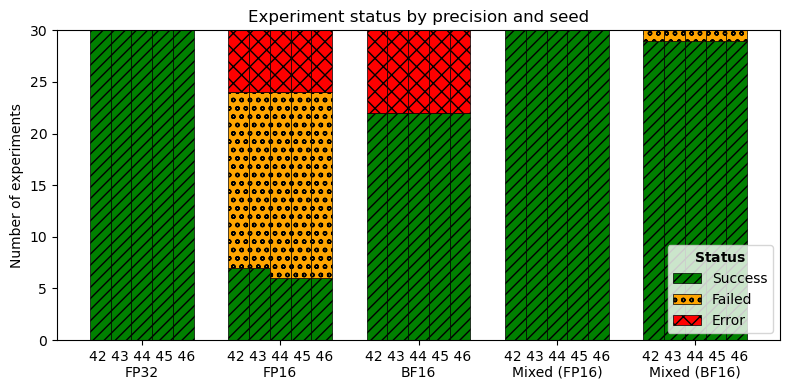

In [80]:
colors = {
    "num_success": "green",
    "num_failed":  "orange",
    "num_error":   "red"
}

# Add patterns to bars
patterns = ['///', 'oo', 'xx']

formatted = np.arange(len(orders["precision"])) # base positions
bar_width = 0.15

fig, ax = plt.subplots(figsize=(8,4))

for i, seed in enumerate(orders["seed"]):
    subset = num_failed_df[num_failed_df["seed"] == seed]
    bottoms = np.zeros(len(subset))

    for col, pattern in zip(colors.keys(), patterns):
        ax.bar(
            formatted + (i - 1) * bar_width, # Move each seed bars
            subset[col].values,
            bar_width,
            bottom=bottoms,
            color=colors[col],
            linewidth=0.5,
            edgecolor="black",
            hatch=pattern
        )
        bottoms += subset[col].values


ax.set_xticks(formatted + bar_width)
precision_labels = labels["precision"]
ax.set_xticklabels([f"42 43 44 45 46\n{precision_labels[precision]}" for precision in orders["precision"]])

ax.set_ylabel("Number of experiments")

ax.set_title("Experiment status by precision and seed")


ax.legend(["Success","Failed","Error"], title=r"$\bf{Status}$", loc="lower right")

plt.tight_layout()
plt.show()

save_plot(fig, "status")

In [81]:
num_failed_df[["num_success", "num_failed", "num_error"]].sum()

num_success    587
num_failed      93
num_error       70
dtype: int64

### Test metrics

In [82]:
test_metric_df = test_df.melt(
    id_vars=experiment_config,
    value_vars=["loss", "metric"],
    var_name="measure",
    value_name="value"
)
test_metric_df.head()

backend model_type model_complexity precision seed measure     value
0     jax        mlp           simple      fp32   42    loss  0.282897
1     jax        mlp           simple      fp32   43    loss  0.284469
2     jax        mlp           simple      fp32   44    loss  0.287033
3     jax        mlp           simple      fp32   45    loss  0.281953
4     jax        mlp           simple      fp32   46    loss  0.279295

In [83]:
def add_patterns_test(ax):
    patterns = ['///', '\\\\', 'xx', 'oo', '...']

    # Add patterns to bars
    for bars, pattern in zip(ax.containers, patterns):
        for bar in bars:
            bar.set_hatch(pattern)
            bar.set_edgecolor('black')


In [84]:
def plot_test_results(df: pd.DataFrame, model: str, complexity: str, loss_name: str, metric_name: str, log=False):
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.barplot(
        data=plot_df.query("measure=='loss'"),
        x="backend",
        y="value",
        hue="precision",
        ax=axes[0]
    )

    add_patterns_test(axes[0])

    axes[0].set_title(f"Loss ({loss_name})")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Loss")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
    axes[0].legend_.remove()


    sns.barplot(
        data=plot_df.query("measure=='metric'"),
        x="backend",
        y="value",
        hue="precision",
        ax=axes[1]
    )
    
    add_patterns_test(axes[1])

    axes[1].set_title(f"{metric_name}")
    axes[1].set_xlabel("")
    axes[1].set_ylabel(f"{metric_name}")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
    axes[1].legend_.remove()

    # Legend
    handles, leg_labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(
        handles,
        leg_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(leg_labels)
    )

    # Add patterns to legend
    handles = legend.legend_handles
    for handle, pattern in zip(handles, ['///', '\\\\', 'xx', 'oo', '...']):
        handle.set_hatch(pattern)
        handle.set_edgecolor('black')

    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]

    fig.suptitle(f"Test results ({model} - {complexity})", y=1.05)

    if log:
        for _, ax in enumerate(axes.flat):
            ax.set(yscale="log")
            ax.set_ylabel(ax.get_ylabel() + " (log)")

    plt.tight_layout(w_pad=3)
    save_plot(fig, f"{model}/test_res_{model}_{complexity}")

    plt.show()

/tmp/ipykernel_245412/1451610533.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_245412/1451610533.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


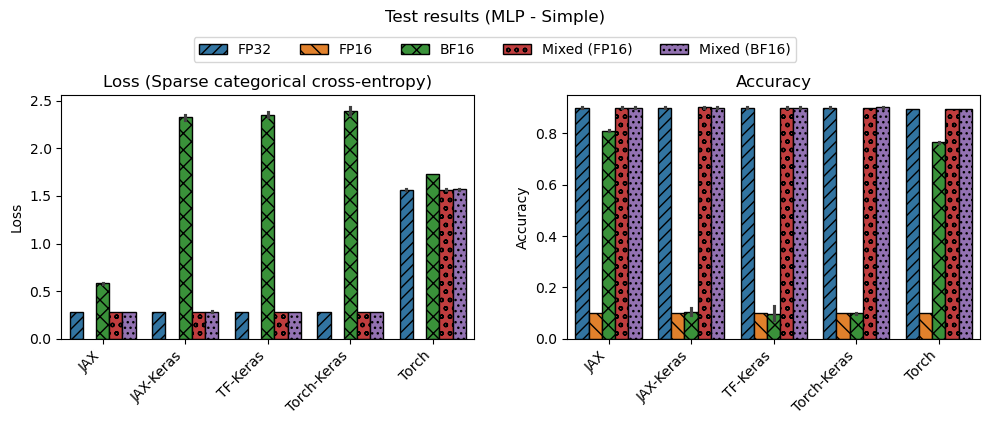

/tmp/ipykernel_245412/1451610533.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_245412/1451610533.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


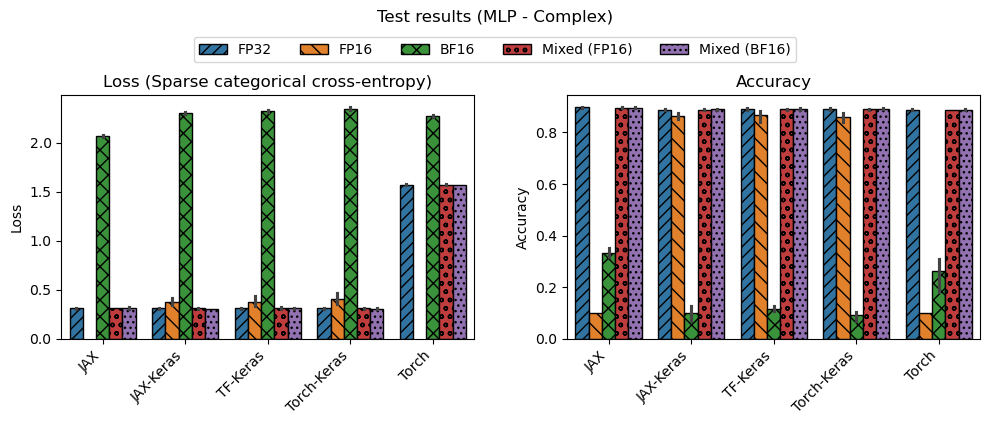

/tmp/ipykernel_245412/1451610533.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_245412/1451610533.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


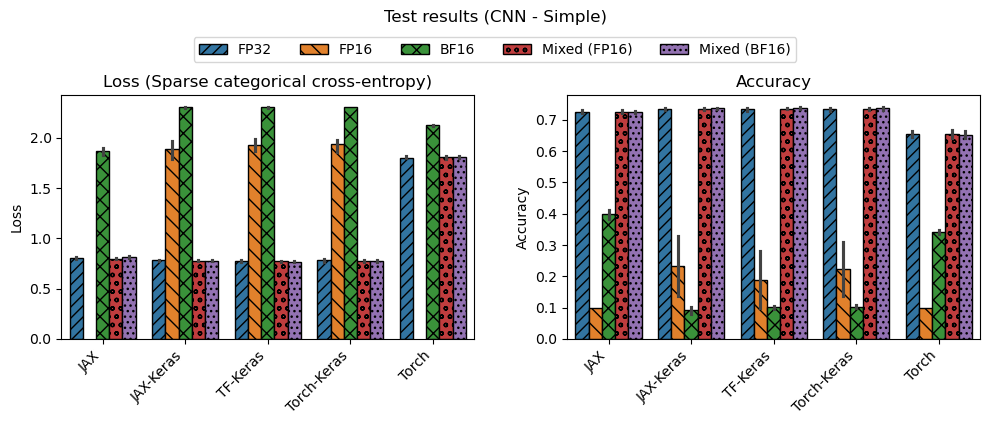

/tmp/ipykernel_245412/1451610533.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_245412/1451610533.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


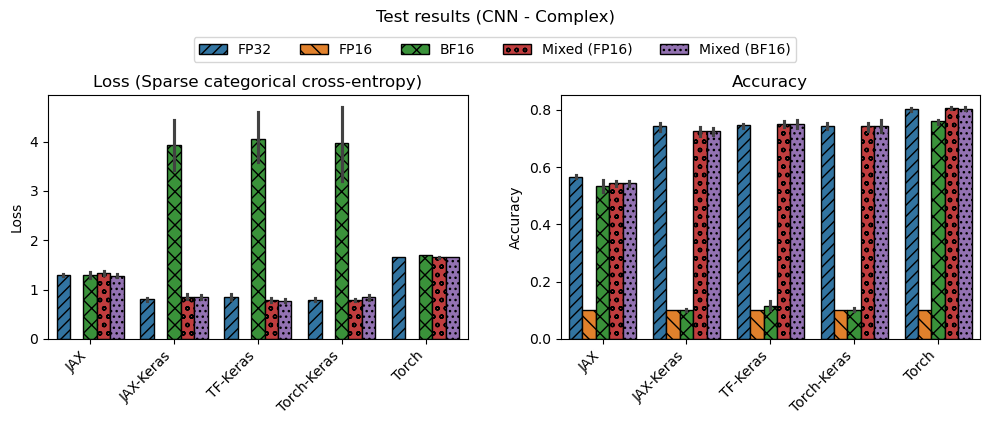

/tmp/ipykernel_245412/1451610533.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_245412/1451610533.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


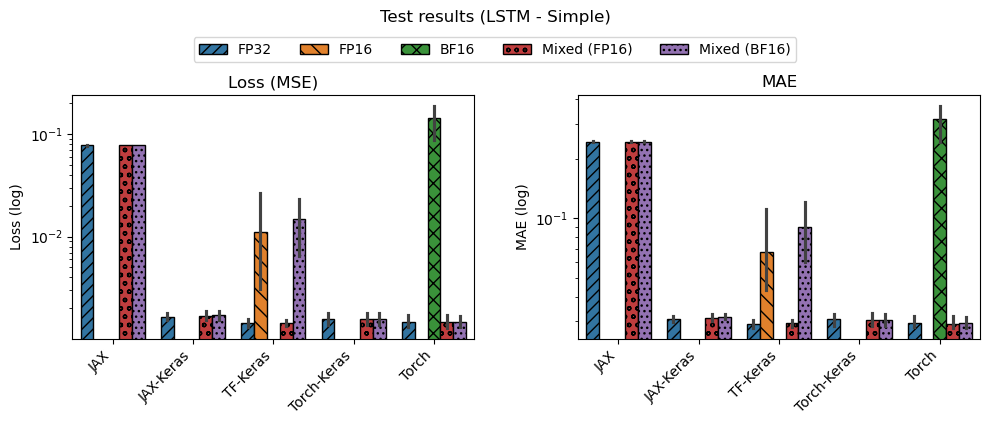

/tmp/ipykernel_245412/1451610533.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_245412/1451610533.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


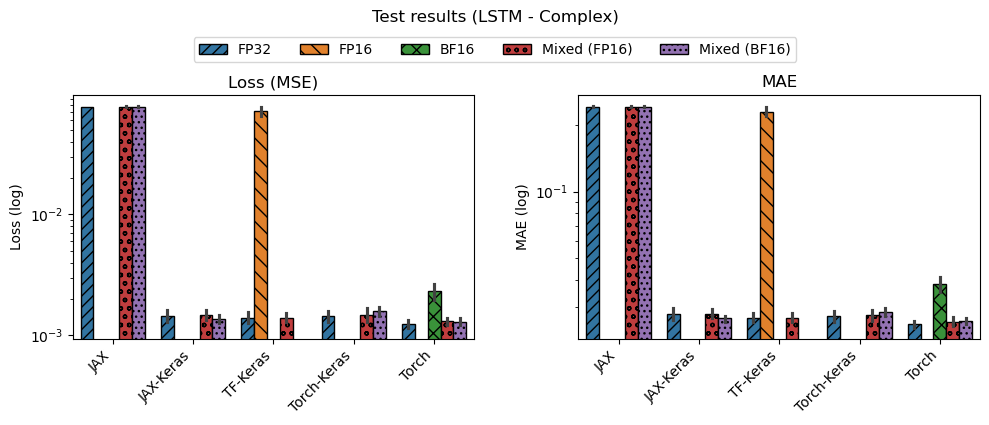

In [85]:
mapping = {
    "mlp": ("Sparse categorical cross-entropy", "Accuracy", False),
    "cnn": ("Sparse categorical cross-entropy", "Accuracy", False),
    "lstm": ("MSE", "MAE", True),
}

for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        loss_name, metric_name, log = mapping[model]
        plot_test_results(test_metric_df, model, complexity, loss_name, metric_name, log)

In [86]:
base_df = test_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["loss"]
    .mean()
    .reset_index()
)
ref = base_df["loss"].min()
base_df["comp"] = 1 - (base_df["loss"] / ref)
base_df = base_df.sort_values(by="loss", ascending=True)
base_df.head()

backend model_type model_complexity      loss       comp
22  torch-keras       lstm           simple  0.001583   0.000000
10    jax-keras       lstm           simple  0.001692  -0.069125
16     tf-keras       lstm           simple  0.007203  -3.551659
28        torch       lstm           simple  0.036930 -22.335677
4           jax       lstm           simple  0.077904 -48.226176

In [87]:
base_df = test_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = base_df[base_df["precision"].isin(["fp32", "mixed_fp16", "mixed_bf16"])] # Remove half precision due to bad results
base_df = (
    base_df.groupby(experiment_config[:-2])["loss"]
    .mean()
    .reset_index()
)
ref = base_df["loss"].min()
base_df["comp"] = 1 - (base_df["loss"] / ref)
base_df = base_df.sort_values(by="loss", ascending=True)
base_df.head()

backend model_type model_complexity      loss       comp
28        torch       lstm           simple  0.001465   0.000000
22  torch-keras       lstm           simple  0.001583  -0.080279
10    jax-keras       lstm           simple  0.001692  -0.154953
16     tf-keras       lstm           simple  0.005878  -3.012531
4           jax       lstm           simple  0.077904 -52.177985

In [88]:
# For LSTM, half precision show puntual bad results that distorts the mean
base_df = test_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = base_df[base_df["precision"].isin(["fp32", "mixed_fp16", "mixed_bf16"])]
base_df = (
    base_df.groupby(experiment_config[:-1])["loss"]
    .mean()
    .reset_index()
)
base_df = (
    base_df.groupby(experiment_config[:-2])["loss"]
    .agg(["min", "mean"])
    .reset_index()
)
ref = base_df["min"].min()
base_df["comp_min"] = 1 - (base_df["min"] / ref)
ref = base_df["mean"].min()
base_df["comp_mean"] = 1 - (base_df["mean"] / ref)
base_df = base_df.sort_values(by="min", ascending=True)
base_df.head()

backend model_type model_complexity       min      mean   comp_min  \
16     tf-keras       lstm           simple  0.001423  0.005878   0.000000   
28        torch       lstm           simple  0.001458  0.001465  -0.024869   
22  torch-keras       lstm           simple  0.001575  0.001583  -0.106795   
10    jax-keras       lstm           simple  0.001662  0.001692  -0.168033   
4           jax       lstm           simple  0.077761  0.077904 -53.658392   

    comp_mean  
16  -3.012531  
28   0.000000  
22  -0.080279  
10  -0.154953  
4  -52.177985

In [89]:
test_df.query("model_type=='cnn' and model_complexity=='complex' and precision=='fp16'").head()

backend model_type model_complexity precision seed      time  loss  \
80     jax        cnn          complex      fp16   42  3.359147   NaN   
81     jax        cnn          complex      fp16   43  3.369644   NaN   
82     jax        cnn          complex      fp16   44  3.363093   NaN   
83     jax        cnn          complex      fp16   45  3.408941   NaN   
84     jax        cnn          complex      fp16   46  3.355224   NaN   

      metric  
80  0.100119  
81  0.100119  
82  0.100119  
83  0.100119  
84  0.100119

In [90]:
base_df = test_df.query("model_type=='lstm' and model_complexity=='simple'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["metric"]
    .mean()
    .reset_index()
)
ref = base_df["metric"].max()
base_df["comp"] = 1 - (base_df["metric"] / ref)
base_df = base_df.sort_values(by="metric", ascending=True)
base_df.head()

backend model_type model_complexity    metric      comp
22  torch-keras       lstm           simple  0.030681  0.874413
10    jax-keras       lstm           simple  0.031270  0.872002
16     tf-keras       lstm           simple  0.054000  0.778960
28        torch       lstm           simple  0.101297  0.585360
4           jax       lstm           simple  0.244300  0.000000

## Summary

In [91]:
seed_variability = []

for metric in ["energy", "energy_per_hour"]:
    for (backend, model, model_complexity, precision), df in total_energy_df.groupby(experiment_config[:-1]):
        values = df.sort_values("seed")[metric]
        
        mean = values.mean()
        std = values.std()

        seed_variability.append({
            "backend": backend,
            "model_type": model,
            "model_complexity": model_complexity,
            "precision": precision,
            "metric": metric,
            "mean": mean,
            "std": std
        })

energy_variability_df = pd.DataFrame(seed_variability)

In [92]:
metrics_cfg = {
        "training_time": {
            "label": "Training time (s)",
            "best": "min"
        },
        "testing_time": {
            "label": "Testing time (s)",
            "best": "min"
        },
        "train_gpu_utilization_mean": {
            "label": "Mean GPU usage (%)",
            "best": "max"
        },
        "energy": {
            "label": "Total energy (kJ)",
            "best": "min"
        },
        "energy_per_hour": {
            "label": "Energy per hour (kJ/h)",
            "best": "min"
        },
        "test_loss_mean": {
            "label": "Test loss",
            "best": "min"
        },
        "test_metric_mean": {
            "label": "Test metric",
            "best": "max"
        }
    }


In [93]:
summary_df = pd.concat(
    [variability_df[energy_variability_df.columns],
    energy_variability_df]
).reset_index(drop=True)

summary_df = summary_df[summary_df["metric"].isin(metrics_cfg.keys())]
summary_df.head()

backend model_type model_complexity   precision         metric        mean  \
0     jax        cnn          complex        bf16  training_time  590.600243   
1     jax        cnn          complex        fp16  training_time  601.265717   
2     jax        cnn          complex        fp32  training_time  603.572845   
3     jax        cnn          complex  mixed_bf16  training_time  652.155259   
4     jax        cnn          complex  mixed_fp16  training_time  638.159622   

         std  
0   2.717324  
1  11.456277  
2   4.486856  
3  19.011013  
4   7.113582

In [120]:
label_map = {k: v["label"] for k, v in metrics_cfg.items()}
best_by_label = {v["label"]: v["best"] for v in metrics_cfg.values()}
ordered_labels = [v["label"] for v in metrics_cfg.values()]

In [169]:
def get_pivot_table(df: pd.DataFrame, index: list[str]) -> pd.DataFrame:

    # Keep only relevant columns
    df["metric"] = df["metric"].map(label_map)

    # Create pivot table
    pivot_table = df.pivot_table(
        index=index,
        columns="metric",
        values=["mean", "std"],
        aggfunc="first",
        sort=False
    )

    # Reorder columns
    ordered_cols = [
        (val, metric)
        for metric in ordered_labels
        for val in ("mean", "std")
    ]
    pivot_table = pivot_table.loc[:, ordered_cols]

    return pivot_table

In [170]:
def get_best_values(
    mean_vals: pd.Series,
    best_type: str
) -> tuple[list, list]:
    
    # Global best
    if best_type == "min":
        best_global_val = mean_vals.min(skipna=True)
        is_best_global = np.isclose(mean_vals, best_global_val, equal_nan=False)
    else:
        best_global_val = mean_vals.max(skipna=True)
        is_best_global = np.isclose(mean_vals, best_global_val, equal_nan=False)

    # Best by backend
    if best_type == "min":
        is_best_by_backend = mean_vals.eq(
            mean_vals.groupby(level="backend").transform("min")
        )
    else:
        is_best_by_backend = mean_vals.eq(
            mean_vals.groupby(level="backend").transform("max")
    )

    return is_best_global.tolist(), is_best_by_backend.tolist()

In [171]:
def format_cell(mean: float, std: float, bold, underline, sci_notation) -> str:
    if pd.isna(mean):
        return "--"
    
    def decorate(text: str) -> str:
        if underline:
            text = f"\\underline{{{text}}}"
        
        if bold:
            text = f"\\textbf{{{text}}}"

        return text 
    
    if sci_notation:
        mean_str = f"{mean:.2e}"
        std_str  = f"{std:.2e}"
    else:
        mean_str = f"{mean:.2f}"
        std_str  = f"{std:.2f}"

    mean_str = decorate(mean_str)
    std_str  = decorate(std_str)

    formatted = f"{mean_str} \\\\ $\\pm$ {std_str}"
    formatted = f"\\makecell[r]{{{formatted}}}"

    return formatted

In [172]:
def format_table(
    pivot_table: pd.DataFrame,
    model: str,
    sci_notation: list[str],
    show_best: bool
) -> pd.DataFrame:
    
    latex_table = pivot_table.copy()

    # Add bold and underline to best values
    for metric in ordered_labels:
        mean_vals: pd.Series = pivot_table[("mean", metric)]
        std_vals: pd.Series = pivot_table[("std", metric)]
        use_sci_notation = metric in sci_notation
        best_type = "min" if model == "lstm" and metric == "Test metric" else best_by_label[metric] # Lower is better for LSTM test metric (MAE)

        if show_best:
            is_best_global, is_best_by_backend = get_best_values(mean_vals, best_type)

        else:
            is_best_global = [False] * len(mean_vals)
            is_best_by_backend = [False] * len(mean_vals)

        zipped_values = zip(
            mean_vals.tolist(),
            std_vals.tolist(),
            is_best_global,
            is_best_by_backend,
        )
        
        latex_table[("mean", metric)] = [
            format_cell(mean, std, bold, underline, use_sci_notation) for mean, std, bold, underline in zipped_values
        ]

    # Remove std
    latex_table = latex_table.drop(columns="std", level=0)
    latex_table.columns = latex_table.columns.droplevel(0)

    return latex_table

In [173]:
def save_to_latex(latex_table: pd.DataFrame, output_path: str, caption: str, label: str) -> pd.DataFrame:
    # Save to latex
    latex_table.to_latex(
        output_path,
        index=True,
        multirow=True,
        escape=False,
        caption=caption,
        label=label
    )

    # Change \cline with empty lines
    with open(output_path, "r", encoding="utf-8") as f:
        content = f.read()

    content = re.sub(r"\\cline\{1-[0-9]+\}", "&  &  &  &  &  &  &  &  \\\\\\\\", content)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(content)

    return latex_table

In [186]:
def summary_table(df: pd.DataFrame, model: str, complexity: str, show_best: bool = True, sci_notation: list[str] = []) -> pd.DataFrame:
    plot_df = df.query("model_type==@model and model_complexity==@complexity")
    plot_df = add_labels(plot_df)

    # Replace precision names
    plot_df["precision"] = (
        plot_df["precision"]
        .replace({
            "Mixed (FP16)": "Mixed-FP16",
            "Mixed (BF16)": "Mixed-BF16"
        })
    )

    # Create the table
    pivot_table = get_pivot_table(plot_df, index=["backend", "precision"])
    latex_table = format_table(pivot_table, model, sci_notation, show_best)

    # Rename index columns
    latex_table = latex_table.rename_axis(index=["Framework", "Precision"], columns="")

    # Caption
    model = labels["model_type"][model]
    caption = (
        f"Summary of results for {model} ({complexity}). "
        "Represented values are the mean $\\pm$ standard deviation across the seeds."
    )

    if show_best:
        caption += (
            " The best overall values are shown in \\textbf{bold}, "
            "while the best values within each framework are \\underline{underlined}."
        )
    
    output_path = f"img/summary_table_{model}_{complexity}.tex"
    label=f"tab:summary_{model}_{complexity}"

    latex_table = save_to_latex(latex_table, output_path, caption, label)

    return latex_table


In [187]:
ordered_labels

['Training time (s)',
 'Testing time (s)',
 'Mean GPU usage (%)',
 'Total energy (kJ)',
 'Energy per hour (kJ/h)',
 'Test loss',
 'Test metric']

In [ ]:
#summary_table(summary_df, "mlp", "complex")
summary_table(summary_df, "lstm", "simple", sci_notation=["Test loss"])

In [177]:
comparison_df = summary_df.groupby(experiment_config[:-2] + ["metric"])[["mean", "std"]].median().reset_index()
comparison_df.head()

backend model_type model_complexity            metric        mean       std
0     jax        cnn          complex            energy   81.839375  0.811886
1     jax        cnn          complex   energy_per_hour  461.703433  6.630292
2     jax        cnn          complex    test_loss_mean    1.297941  0.045379
3     jax        cnn          complex  test_metric_mean    0.842739  0.003338
4     jax        cnn          complex      testing_time    3.381193  0.021755

In [182]:
def comparison_summary_table(df: pd.DataFrame, model: str, show_best: bool = True, sci_notation: list[str] = []):
    plot_df = df.query("model_type==@model")
    plot_df = add_labels(plot_df)
    plot_df = plot_df.sort_values(by=["backend", "model_complexity"])

    # Create the table
    pivot_table = get_pivot_table(plot_df, index=["backend", "model_complexity"])
    latex_table = format_table(pivot_table, model, sci_notation, show_best)

    # Rename index columns
    latex_table = latex_table.rename_axis(index=["Framework", "Version"], columns="")

    # Caption
    model = labels["model_type"][model]
    caption = (
        f"Comparison of results for both {model} versions. "
        "Represented values are the median of the results across precision formats $\\pm$ the median of the standard deviation across precision formats."
    )

    if show_best:
        caption += (
            " The best overall values are shown in \\textbf{bold}, "
            "while the best values within each framework are \\underline{underlined}."
        )
    
    # Save to latex
    output_path = f"img/comparison_table_{model}.tex"
    label=f"tab:comparison_{model}"
    latex_table = save_to_latex(latex_table, output_path, caption, label)

    return latex_table


In [ ]:
#comparison_summary_table(comparison_df, "mlp", show_best=False)
comparison_summary_table(comparison_df, "lstm", show_best=False, sci_notation=["Test loss"])

Training time (s)  \
Framework   Version                                         
JAX         Simple     \makecell[r]{372.33 \\ $\pm$ 1.47}   
            Complex    \makecell[r]{882.06 \\ $\pm$ 4.35}   
JAX-Keras   Simple     \makecell[r]{319.00 \\ $\pm$ 2.89}   
            Complex    \makecell[r]{613.68 \\ $\pm$ 3.47}   
TF-Keras    Simple     \makecell[r]{188.81 \\ $\pm$ 7.84}   
            Complex   \makecell[r]{423.37 \\ $\pm$ 11.29}   
Torch-Keras Simple   \makecell[r]{4666.99 \\ $\pm$ 84.40}   
            Complex  \makecell[r]{7152.11 \\ $\pm$ 86.12}   
Torch       Simple      \makecell[r]{89.10 \\ $\pm$ 3.27}   
            Complex    \makecell[r]{215.23 \\ $\pm$ 2.59}   

                                      Testing time (s)  \
Framework   Version                                      
JAX         Simple    \makecell[r]{2.62 \\ $\pm$ 0.47}   
            Complex   \makecell[r]{4.55 \\ $\pm$ 0.14}   
JAX-Keras   Simple    \makecell[r]{2.69 \\ $\pm$ 0.48}   
            Complex   \makecell[r]{3.58 \\ $\pm$ 0.05}   
TF-Keras    Simple    \makecell[r]{2.43 \\ $\pm$ 0.03}   
            Complex   \makecell[r]{2.41 \\ $\pm$ 0.03}   
Torch-Keras Simple   \makecell[r]{11.02 \\ $\pm$ 0.00}   
            Complex  \makecell[r]{16.22 \\ $\pm$ 0.45}   
Torch       Simple    \makecell[r]{1.01 \\ $\pm$ 0.01}   
            Complex   \makecell[r]{1.01 \\ $\pm$ 0.00}   

                                    Mean GPU usage (%)  \
Framework   Version                                      
JAX         Simple   \makecell[r]{80.01 \\ $\pm$ 0.35}   
            Complex  \makecell[r]{73.60 \\ $\pm$ 0.63}   
JAX-Keras   Simple   \makecell[r]{85.35 \\ $\pm$ 0.55}   
            Complex  \makecell[r]{88.18 \\ $\pm$ 0.42}   
TF-Keras    Simple   \makecell[r]{59.94 \\ $\pm$ 1.38}   
            Complex  \makecell[r]{75.79 \\ $\pm$ 1.06}   
Torch-Keras Simple   \makecell[r]{16.18 \\ $\pm$ 0.44}   
            Complex  \makecell[r]{18.92 \\ $\pm$ 0.20}   
Torch       Simple   \makecell[r]{20.30 \\ $\pm$ 0.65}   
            Complex  \makecell[r]{73.15 \\ $\pm$ 0.66}   

                                      Total energy (kJ)  \
Framework   Version                                       
JAX         Simple    \makecell[r]{26.15 \\ $\pm$ 0.20}   
            Complex   \makecell[r]{80.56 \\ $\pm$ 1.62}   
JAX-Keras   Simple    \makecell[r]{22.82 \\ $\pm$ 0.29}   
            Complex   \makecell[r]{63.01 \\ $\pm$ 0.78}   
TF-Keras    Simple    \makecell[r]{13.17 \\ $\pm$ 0.57}   
            Complex   \makecell[r]{45.34 \\ $\pm$ 1.25}   
Torch-Keras Simple   \makecell[r]{309.15 \\ $\pm$ 4.49}   
            Complex  \makecell[r]{506.17 \\ $\pm$ 7.92}   
Torch       Simple     \makecell[r]{5.94 \\ $\pm$ 0.22}   
            Complex   \makecell[r]{25.35 \\ $\pm$ 0.27}   

                                 Energy per hour (kJ/h)  \
Framework   Version                                       
JAX         Simple   \makecell[r]{252.81 \\ $\pm$ 1.75}   
            Complex  \makecell[r]{337.62 \\ $\pm$ 5.85}   
JAX-Keras   Simple   \makecell[r]{255.13 \\ $\pm$ 1.92}   
            Complex  \makecell[r]{377.98 \\ $\pm$ 5.09}   
TF-Keras    Simple   \makecell[r]{251.02 \\ $\pm$ 1.44}   
            Complex  \makecell[r]{382.05 \\ $\pm$ 4.97}   
Torch-Keras Simple   \makecell[r]{238.47 \\ $\pm$ 0.90}   
            Complex  \makecell[r]{254.79 \\ $\pm$ 1.48}   
Torch       Simple   \makecell[r]{240.56 \\ $\pm$ 1.26}   
            Complex  \makecell[r]{422.31 \\ $\pm$ 4.45}   

                                                    Test loss  \
Framework   Version                                             
JAX         Simple   \makecell[r]{7.79e-02 \\ $\pm$ 5.67e-04}   
            Complex  \makecell[r]{7.76e-02 \\ $\pm$ 2.73e-04}   
JAX-Keras   Simple   \makecell[r]{1.68e-03 \\ $\pm$ 1.92e-04}   
            Complex  \makecell[r]{1.46e-03 \\ $\pm$ 1.86e-04}   
TF-Keras    Simple   \makecell[r]{6.31e-03 \\ $\pm$ 5.74e-03}   
            Complex  \makecell[r]{1.39e-

# Comparison

## Correlation

In [99]:
total_energy_df.head()

backend model_type model_complexity precision seed     energy  \
0     jax        mlp           simple      fp32   42  13.898514   
1     jax        mlp           simple      fp32   43  15.192393   
2     jax        mlp           simple      fp32   44  14.993291   
3     jax        mlp           simple      fp32   45  13.665134   
4     jax        mlp           simple      fp32   46  14.149745   

   training_time  energy_per_hour  
0     218.031574       229.483503  
1     234.050772       233.678420  
2     229.041067       235.660130  
3     204.951069       240.030375  
4     220.036557       231.502813

In [100]:
# Remove error experiments
base_df = total_energy_df[~total_energy_df["training_time"].isna()].copy()
base_df = base_df.sort_values(by=["model_type"])

results = []

for keys, group in base_df.groupby(["model_type"]):
    
    corr = group["training_time"].corr(group["energy"])

    X = group[["training_time"]].values
    y = group["energy"].values

    modelo = LinearRegression().fit(X, y)

    slope_w = modelo.coef_[0] * 1000 # kJ/s -> J/s = W
    intercept = modelo.intercept_
    r2 = modelo.score(X, y)

    results.append({
        "model_type": keys[0],
        "correlation": corr,
        "mean_power_W": slope_w,
        "intercept_kJ": intercept,
        "R2": r2
    })

results_df = pd.DataFrame(results)

results_df.round(5).head()

model_type  correlation  mean_power_W  intercept_kJ       R2
0        mlp      0.99741      68.14135      -0.12311  0.99482
1        cnn      0.98714      74.35164       9.46350  0.97446
2       lstm      0.99604      69.28803       8.11021  0.99209

## Comparison plots

### Model versions comparison

In [101]:
summary_df.head()

backend model_type model_complexity   precision         metric        mean  \
0     jax        cnn          complex        bf16  training_time  590.600243   
1     jax        cnn          complex        fp16  training_time  601.265717   
2     jax        cnn          complex        fp32  training_time  603.572845   
3     jax        cnn          complex  mixed_bf16  training_time  652.155259   
4     jax        cnn          complex  mixed_fp16  training_time  638.159622   

         std  
0   2.717324  
1  11.456277  
2   4.486856  
3  19.011013  
4   7.113582

In [102]:
complex_comp_df = summary_df.pivot_table(
    index=["model_type", "backend", "precision", "metric"],
    columns="model_complexity",
    values="mean"
).reset_index()

complex_comp_df["comp"] = (complex_comp_df["complex"] / complex_comp_df["simple"]) - 1

complex_comp_df.head()

model_complexity model_type backend precision            metric     complex  \
0                       cnn     jax      bf16            energy   78.944925   
1                       cnn     jax      bf16   energy_per_hour  481.228552   
2                       cnn     jax      bf16    test_loss_mean    1.298437   
3                       cnn     jax      bf16  test_metric_mean    0.785860   
4                       cnn     jax      bf16      testing_time    3.390702   

model_complexity      simple      comp  
0                  18.261140  3.323110  
1                 244.712001  0.966510  
2                   1.865625 -0.304020  
3                   0.367395  1.139004  
4                   2.413466  0.404909

In [103]:
def plot_version_increments(df: pd.DataFrame, model: str):
    plot_df = df.query("model_type==@model")
    plot_df = plot_df.groupby(["backend", "metric"])["comp"].median().mul(100).reset_index()

    plot_df = add_labels(plot_df)

    # Remove units from labels
    clean_labels = {
        key: re.sub(r'\s*\(.*?\)', '', value).strip()
        for key, value in label_map.items()
    }
    plot_df["metric"] = plot_df["metric"].map(clean_labels)

    plot = sns.catplot(
        data=plot_df,
        x="metric",
        y="comp",
        kind="bar",
        hue="backend",
        order=clean_labels.values(),
        legend="auto"
    )
    
    add_patterns(plot)
    set_size(plot, width=10)

    model = labels["model_type"][model]

    add_title(plot, f"Metric increments of {model} complex over simple version")
    plot._legend.set_title(r"$\bf{Framework}$")
    plot._legend.set_loc("upper right")
    plot._legend.set_bbox_to_anchor((0.98, 0.93))

    plot.set_axis_labels("Metric", "Increment (%)")
    plot.set_xticklabels(clean_labels.values())

    plt.tight_layout()
    save_plot(plot, f"{model}/version_increments_{model}", format="pdf")

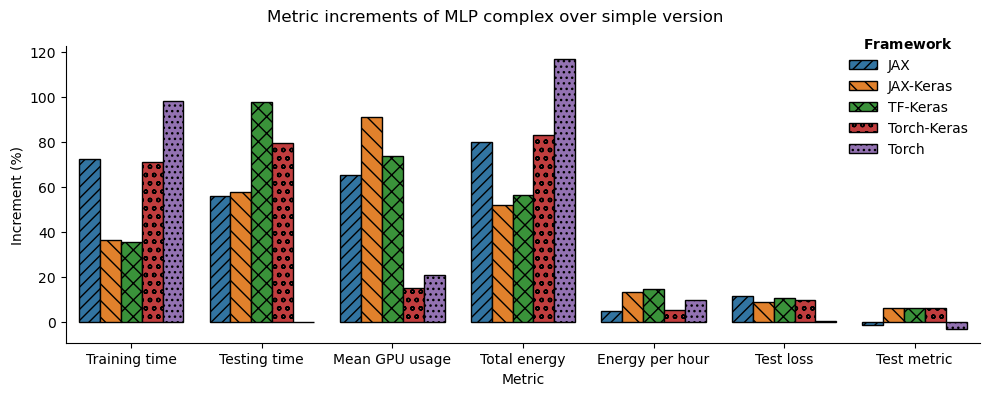

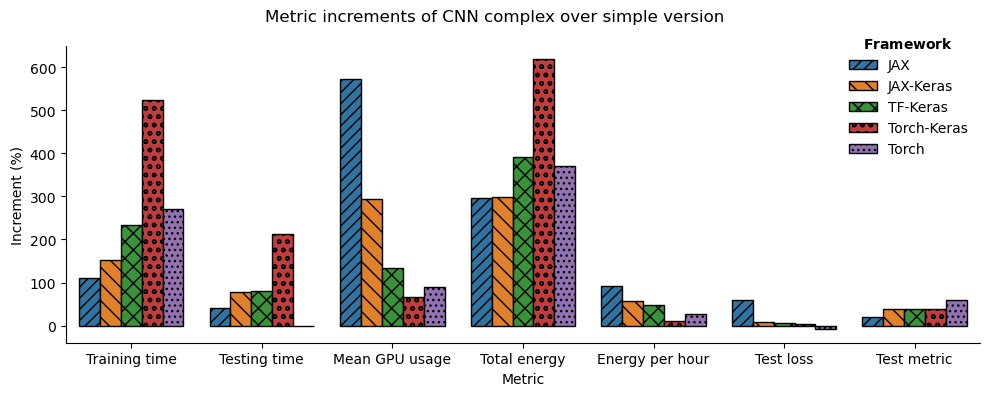

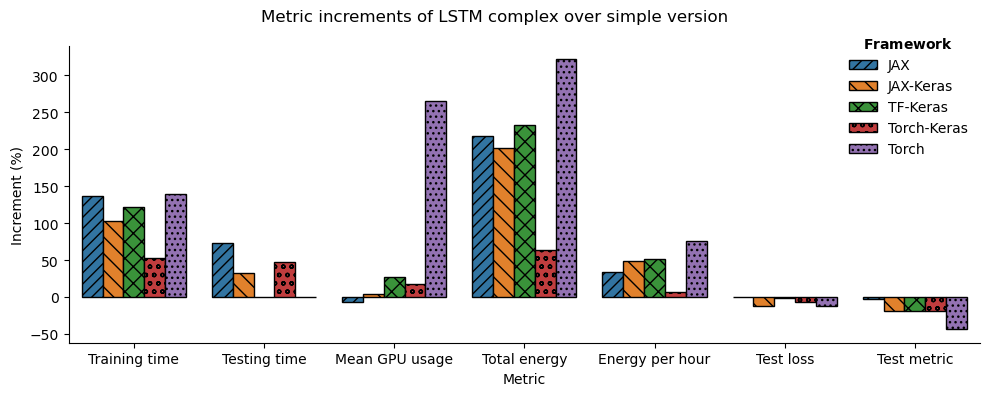

In [104]:
for model in orders["model_type"]:
    plot_version_increments(complex_comp_df, model)

In [105]:
median_comp_df = complex_comp_df.query("model_type=='lstm'")
median_comp_df = median_comp_df.groupby(["backend", "metric"])["comp"].median().mul(100).reset_index()

In [106]:
median_comp_df.query("backend=='torch'").head(7)

backend                      metric        comp
21   torch                      energy  321.496123
22   torch             energy_per_hour   75.957532
23   torch              test_loss_mean  -12.937270
24   torch            test_metric_mean  -43.732565
25   torch                testing_time   -0.199323
26   torch  train_gpu_utilization_mean  265.644080
27   torch               training_time  139.529745

In [107]:
median_comp_df.query("metric=='test_metric_mean'").head(5)

backend            metric       comp
3           jax  test_metric_mean  -2.481182
10    jax-keras  test_metric_mean -19.571213
17     tf-keras  test_metric_mean -19.220225
24        torch  test_metric_mean -43.732565
31  torch-keras  test_metric_mean -18.940955

In [108]:
# Normalize metrics
# Plot area plots for each framework => more area is better

def normalize_metric(values: pd.Series):
    # Normalize to [0, 1]
    normalized = values / values.max()
    
    return normalized

In [109]:
model = "mlp"

plot_df = comparison_df.query("model_type==@model").copy()

plot_df["mean_norm"] = (
    plot_df.groupby(["metric"])["mean"]
    .transform(lambda values: normalize_metric(values))
)

plot_df = add_labels(plot_df)
plot_df["metric"] = plot_df["metric"].map(label_map)

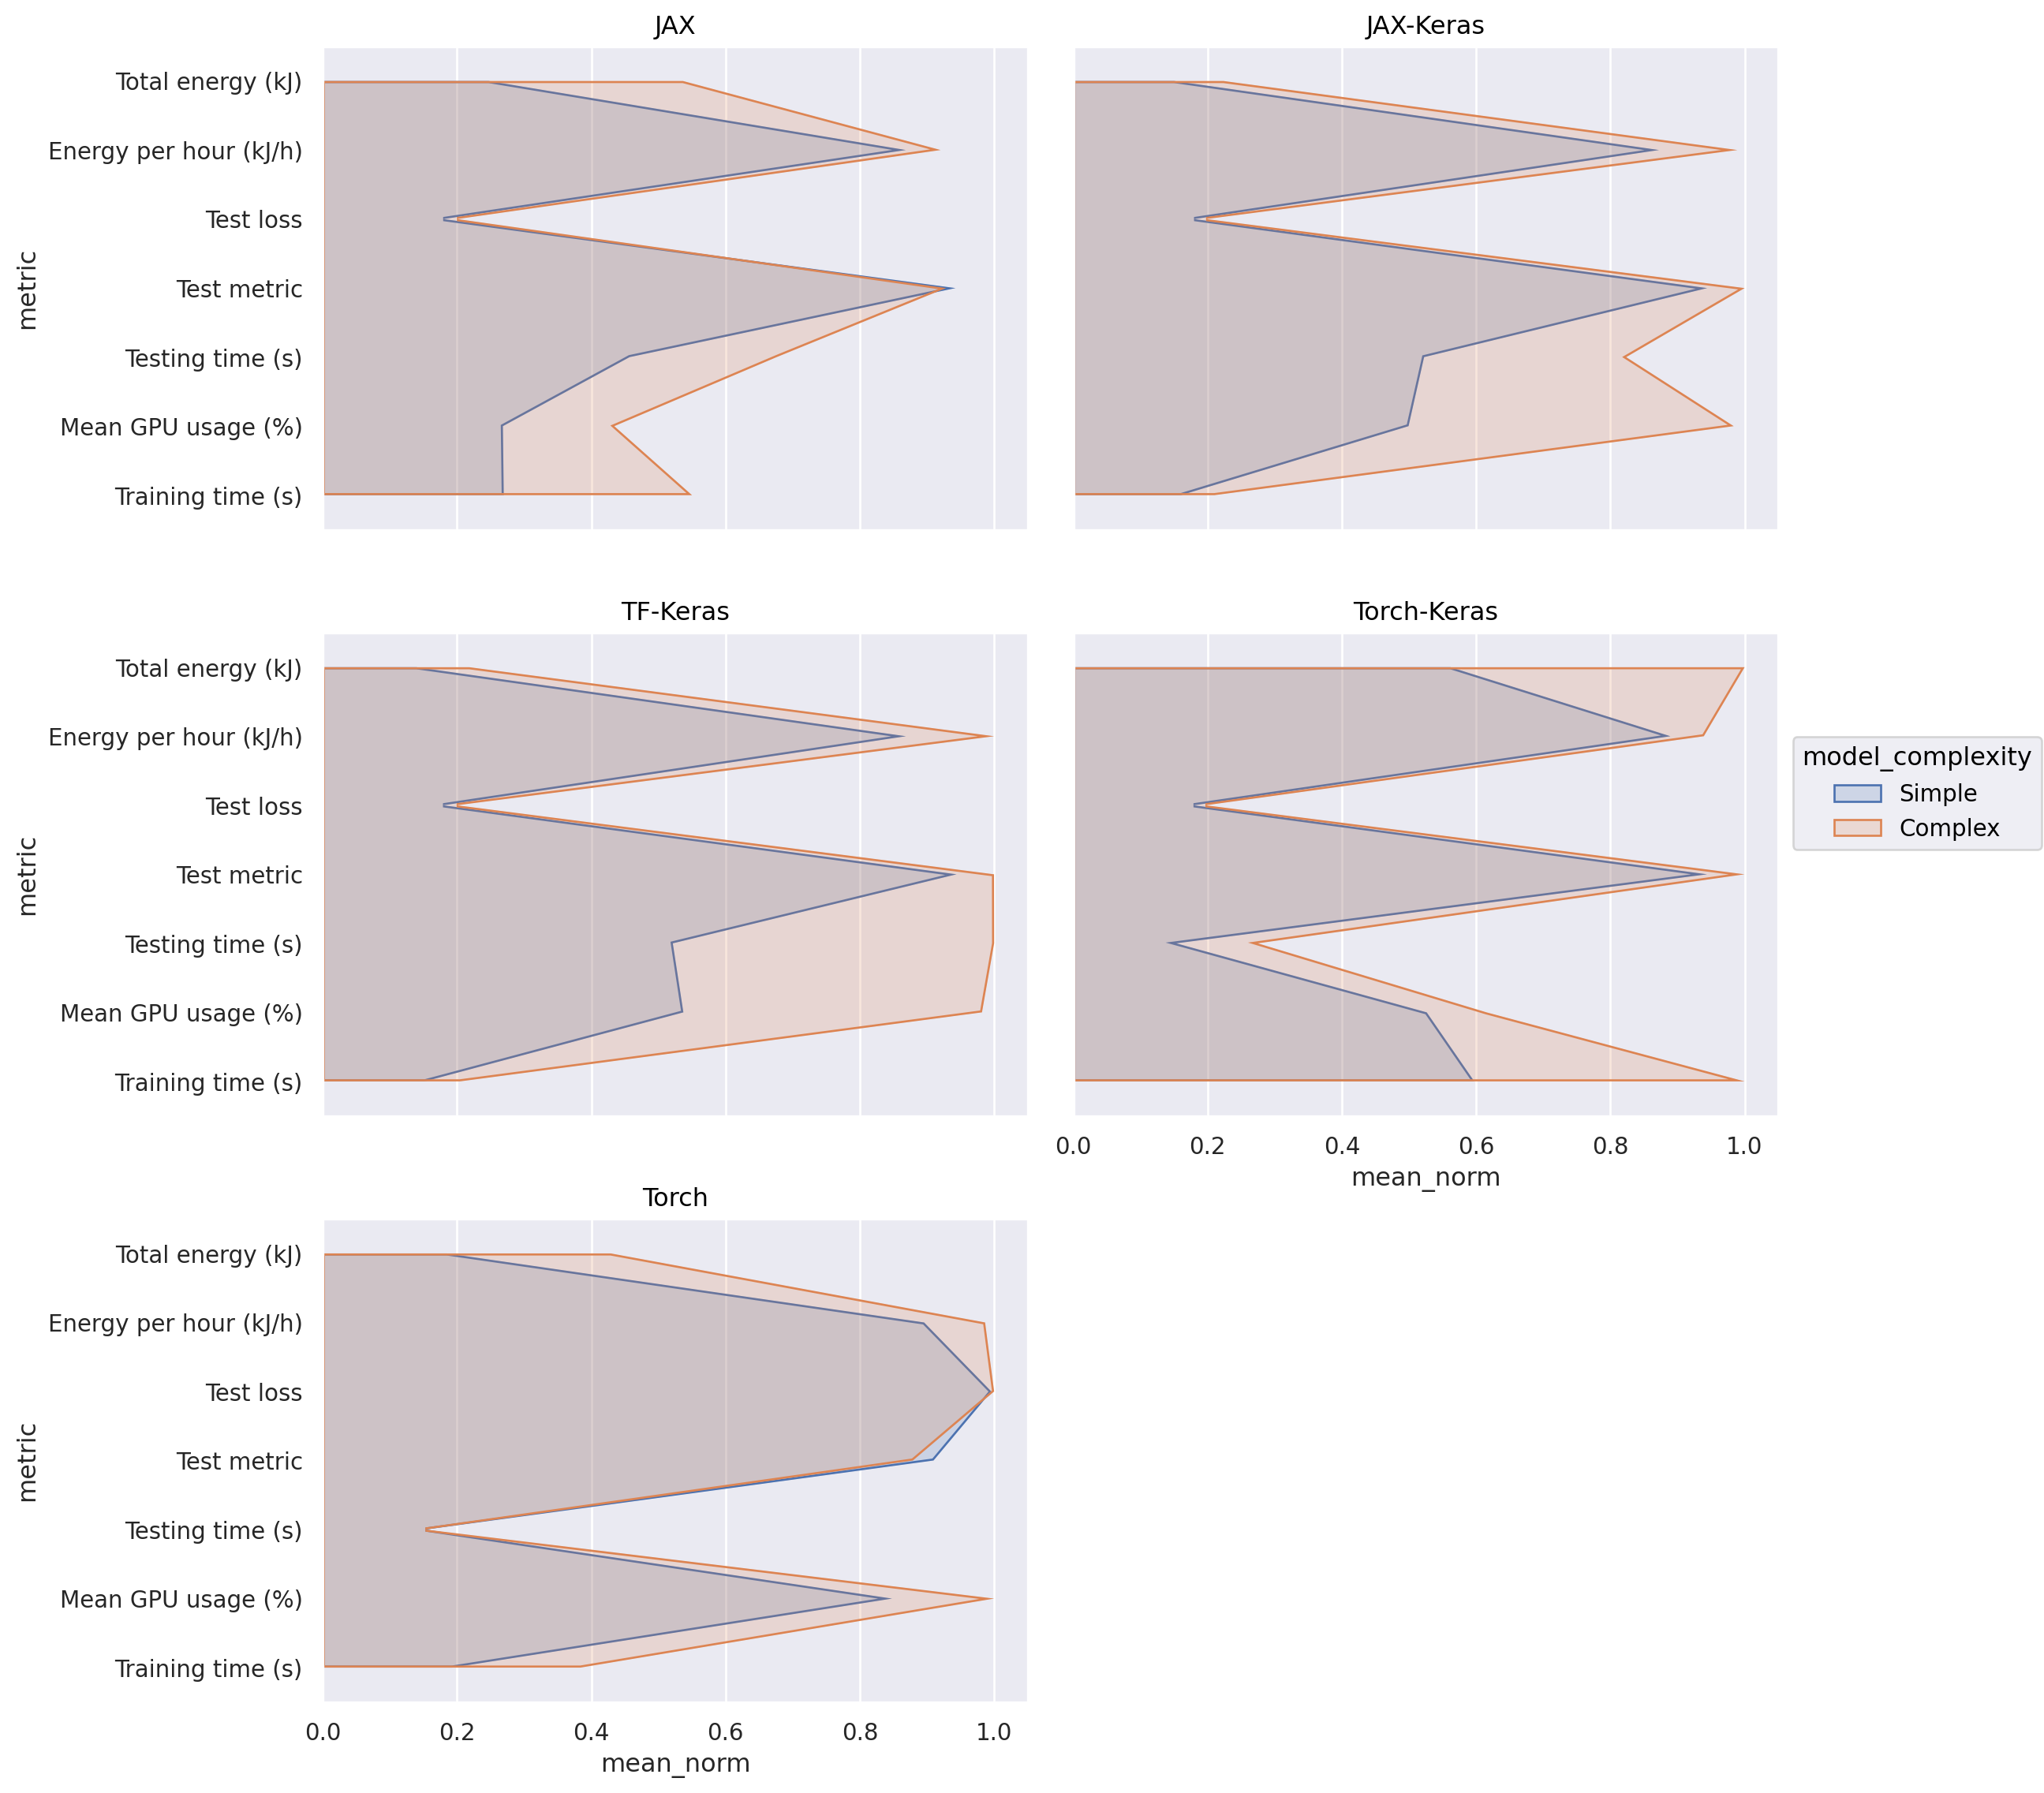

In [110]:
(
    so.Plot(plot_df, y="metric", x="mean_norm", color="model_complexity")
        .facet("backend", wrap=2)
        .add(so.Area())
        .layout(size=(12, 12))
)


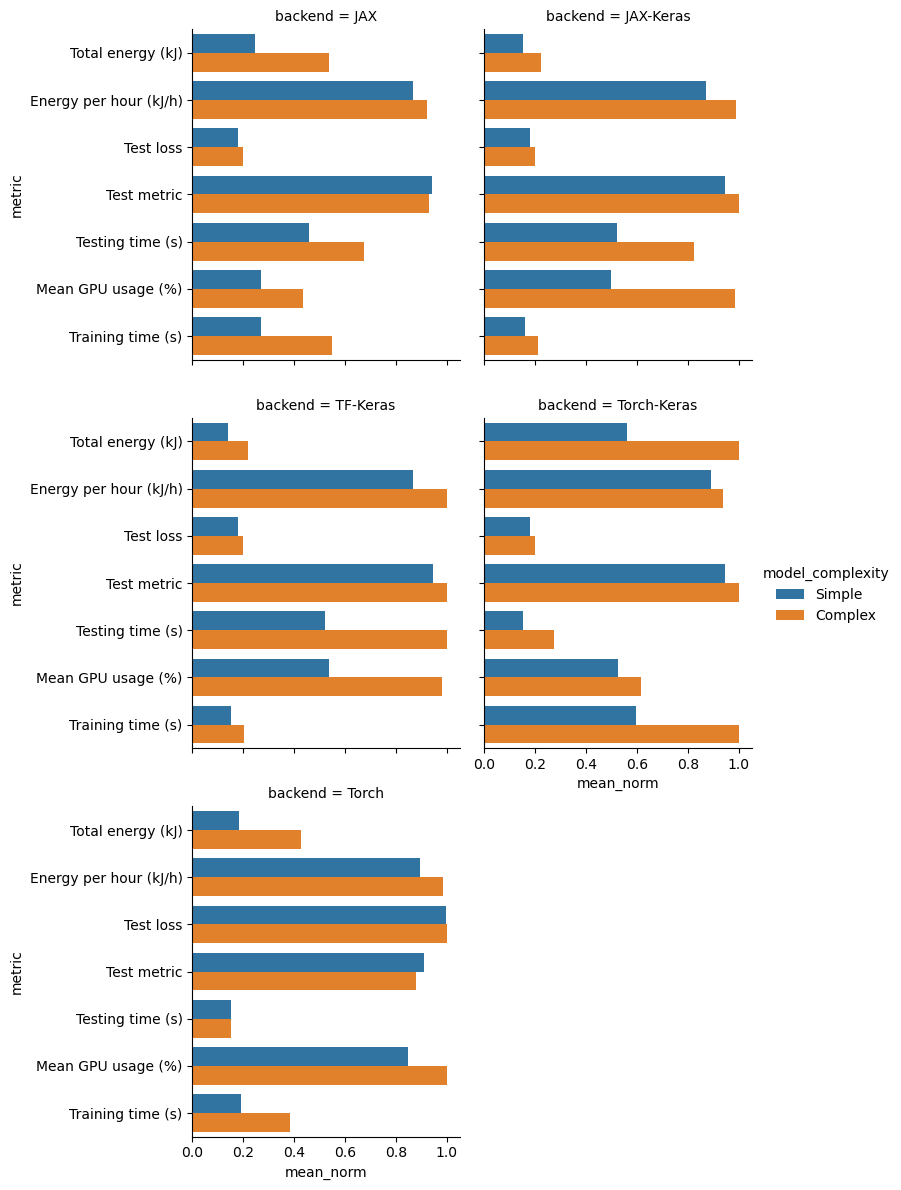

In [111]:
sns.catplot(
    data=plot_df,
    x="mean_norm",
    y="metric",
    hue="model_complexity",
    col="backend",
    col_wrap=2,
    kind="bar",
    height=4,
    aspect=1
)

In [112]:
model = "mlp"

plot_df = comparison_df.query("model_type==@model and model_complexity=='complex'").copy()

plot_df["mean_norm"] = (
    plot_df.groupby(["metric"])["mean"]
    .transform(lambda values: normalize_metric(values))
)

plot_df = add_labels(plot_df)
plot_df["metric"] = plot_df["metric"].map(label_map)

In [113]:
plot_df.head()

backend model_type model_complexity                  metric        mean  \
28     JAX        MLP          Complex       Total energy (kJ)   31.469819   
29     JAX        MLP          Complex  Energy per hour (kJ/h)  242.025265   
30     JAX        MLP          Complex               Test loss    0.315161   
31     JAX        MLP          Complex             Test metric    0.908585   
32     JAX        MLP          Complex        Testing time (s)    4.450083   

    mean_norm  
28   0.536517  
29   0.920323  
30   0.200187  
31   0.928428  
32   0.675982

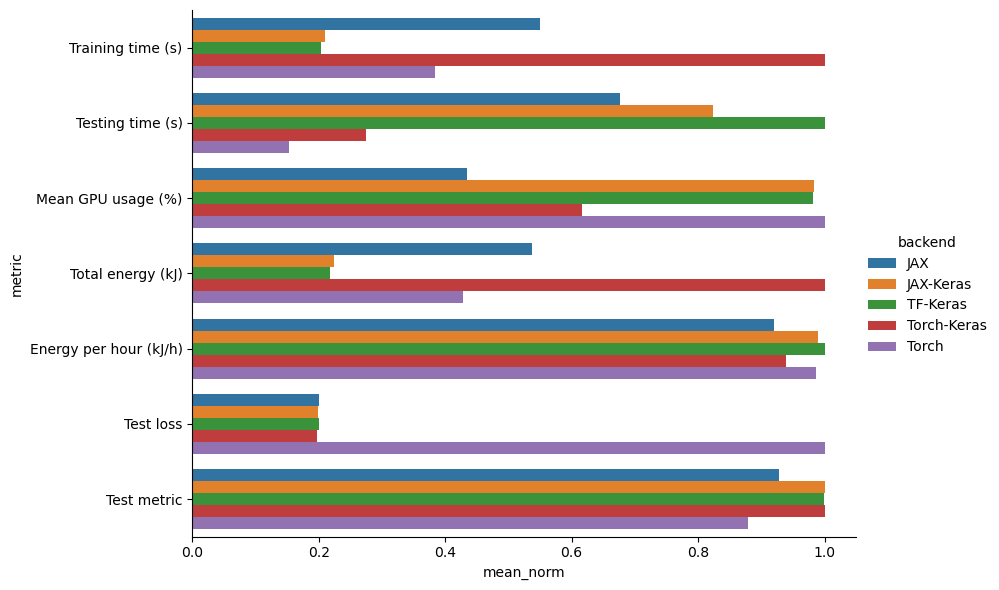

In [114]:
sns.catplot(
    data=plot_df,
    x="mean_norm",
    y="metric",
    hue="backend",
    kind="bar",
    aspect=1.5,
    height=6,
    order=ordered_labels
)

## Vs. plots

In [115]:
# Keep only successful experiments with all seeds
success_df = failed_df[~failed_df["failed"] & ~failed_df["error"]]
mask = (
    success_df.groupby(experiment_config[:-1])["seed"]
    .transform(lambda g: g.count() == len(orders["seed"]))
)
success_df = success_df[mask][experiment_config].drop_duplicates()
success_df.head()

backend model_type model_complexity precision seed
0     jax        cnn          complex      bf16   42
1     jax        cnn          complex      bf16   43
2     jax        cnn          complex      bf16   44
3     jax        cnn          complex      bf16   45
4     jax        cnn          complex      bf16   46

In [116]:
# Add training_time and max_memory
mixed_df = time_df.merge(
    memory_df,
    on="backend",
    how="left"
)

# Add mean GPU usage
mixed_df = mixed_df.merge(
    train_samples_df.groupby(experiment_config)["gpu_2_utilization"].mean().reset_index(name="train_gpu_utilization_mean"),
    on=experiment_config,
    how="left"
)

# Add energy and energy per hour
mixed_df = mixed_df.merge(
    total_energy_df[experiment_config + ["energy_per_hour", "energy"]],
    on=experiment_config,
    how="left"
)

# Add loss and metric
mixed_df = mixed_df.merge(
    test_df,
    on=experiment_config,
    how="left"
)

# Remove unsuccessful experiments
mixed_df = mixed_df.merge(
    success_df,
    on=experiment_config,
    how="inner"
)

mixed_df = (
    mixed_df.groupby(experiment_config[:-1])[["training_time", "max_memory", "train_gpu_utilization_mean", "energy_per_hour", "energy", "loss", "metric"]]
    .mean()
    .reset_index()
)

mixed_df.head()

backend model_type model_complexity   precision  training_time  max_memory  \
0     jax        cnn          complex        bf16     590.600243   60.712097   
1     jax        cnn          complex        fp32     603.572845   60.712097   
2     jax        cnn          complex  mixed_bf16     652.155259   60.712097   
3     jax        cnn          complex  mixed_fp16     638.159622   60.712097   
4     jax        cnn           simple        bf16     268.678145   60.712097   

   train_gpu_utilization_mean  energy_per_hour     energy      loss    metric  
0                   68.952044       481.228552  78.944925  1.298437  0.534873  
1                   70.167767       538.013438  90.203182  1.297445  0.566182  
2                   67.198480       455.484505  82.479159  1.278125  0.544248  
3                   68.244992       461.703433  81.839375  1.333398  0.543551  
4                   10.940820       244.712001  18.261140  1.865625  0.398567

In [117]:
# Remove experiments with bad results (loss higher than median)
mask = mixed_df.groupby("model_type")["loss"].transform("median")
filtered_df = mixed_df[mixed_df["loss"] <= mask]
len(filtered_df)

58

In [118]:
# No half precision experiment remains
filtered_df.query("precision==['fp16', 'bf16']").head()

Empty DataFrame
Columns: [backend, model_type, model_complexity, precision, training_time, max_memory, train_gpu_utilization_mean, energy_per_hour, energy, loss, metric]
Index: []

In [119]:
markers = ["o", "X", "P", "^", "v"]
precision_markers = {precision_labels[precision]: marker for precision, marker in zip(orders["precision"], markers)}
precision_markers

{'FP32': 'o',
 'FP16': 'X',
 'BF16': 'P',
 'Mixed (FP16)': '^',
 'Mixed (BF16)': 'v'}

In [120]:
metrics_cfg["max_memory"] = {
    "label": "Max GPU memory (GB)",
    "best": "min"
}

In [121]:
def get_pareto_df(df, metric_x, metric_y, improvement=0): # Minimum % improvement
    cfg_best_x = metrics_cfg[metric_x]["best"]
    cfg_best_y = metrics_cfg[metric_y]["best"]

    # Sort values by config
    df2 = df[[metric_x, metric_y]].sort_values(
        [metric_x, metric_y],
        ascending=[
            cfg_best_x=="min",
            cfg_best_y=="min"
        ]).reset_index(drop=True)
    
    # Prepare vars depending on best type
    if cfg_best_y == "min":
        best_y = np.inf
        threshold = 1 - improvement
    else:
        best_y = -np.inf
        threshold = 1 + improvement

    # Obtain pareto points
    points = []
    for _, row in df2.iterrows():
        is_best = (row[metric_y] < best_y * threshold) if cfg_best_y == "min" else (row[metric_y] > best_y * threshold)

        if is_best:
            points.append((row[metric_x], row[metric_y]))
            best_y = row[metric_y]

    pareto_df = pd.merge(
        df,
        pd.DataFrame(points, columns=[metric_x, metric_y]),
        on=[metric_x, metric_y]
    )

    return pareto_df

# Test pareto
df = pd.DataFrame([(1,3,'a'),(0,1,'b'),(1,2,'c'),(2,5,'d'),(3,2,'e'),(4,1,'f')], columns=['training_time','train_gpu_utilization_mean','filler'])
df = get_pareto_df(df, 'training_time', 'train_gpu_utilization_mean')
df.head()

training_time  train_gpu_utilization_mean filler
0              1                           3      a
1              0                           1      b
2              2                           5      d

In [122]:
pareto_color = sns.color_palette("deep")[5]

In [123]:
def make_legend(plot):
    
    backend_handles = []
    precision_handles = []

    colors = sns.color_palette(n_colors=5)
    for backend, color in zip(orders["backend"], colors):
        label = labels["backend"][backend]
        backend_handles.append(Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

    for precision in orders["precision"]:
        if (precision in ["fp16", "bf16"]): # There are no experiments with these
            continue
        label = labels["precision"][precision]
        marker = precision_markers[label]
        precision_handles.append(Line2D([0], [0], marker=marker, color='black', linestyle='None', label=label, markersize=10))


    ax = plot.axes.flat[0]

    # Backend legend
    title = titles["backend"]
    legend1 = ax.legend(handles=backend_handles, title=rf"$\bf{{ {title} }}$", loc="upper left", bbox_to_anchor=(1.05, 1))
    ax.add_artist(legend1)

    # Precision legend
    title = titles["precision"]
    legend2 = ax.legend(handles=precision_handles, title=rf"$\bf{{ {title} }}$", loc="upper left", bbox_to_anchor=(1.05, 0.6))

In [124]:
def plot_versus(df, model, complexity, metric_x, metric_y, log_x=False, log_y=False):
    df = df.query("model_type == @model and model_complexity == @complexity")

    plot = sns.relplot(
        data=add_labels(df),
        x=metric_x,
        y=metric_y,
        hue="backend",
        style="precision",
        markers=precision_markers,
        legend=False
    )
    
    ax = plot.axes.flat[0]

    # Labels
    model = labels["model_type"][model]
    complexity = labels["model_complexity"][complexity]
    metric_x_label = metrics_cfg[metric_x]["label"].split(" (")[0]
    metric_y_label = metrics_cfg[metric_y]["label"].split(" (")[0]

    add_title(plot, f"{metric_x_label} vs. {metric_y_label} ({model} - {complexity})", 0.92)

    # Set log scales
    axis_x_label = metrics_cfg[metric_x]["label"]
    axis_y_label = metrics_cfg[metric_y]["label"]

    if log_x:
        ax.set(xscale="log")
        axis_x_label = axis_x_label[:-1] + ", log)"
    
    if log_y:
        ax.set(yscale="log")
        axis_y_label = axis_y_label[:-1] + ", log)"

    plot.set_axis_labels(axis_x_label, axis_y_label)

    # Grid
    ax.grid(True, ls=":", alpha=.4)

    make_legend(plot)

    
    # Pareto frontier
    pareto_df = get_pareto_df(df, metric_x, metric_y)
    pareto_df = add_labels(pareto_df)

    scatter = sns.scatterplot(
        data=pareto_df,
        x=metric_x,
        y=metric_y,
        hue="backend",
        style="precision",
        markers=precision_markers,
        legend=False,
        ax=ax,
        
        edgecolor=pareto_color,
        linewidth=1,
        zorder=5
    )

    line = sns.lineplot(
        data=pareto_df,
        x=metric_x,
        y=metric_y,
        legend=False,
        ax=ax,
        
        color=pareto_color,
        zorder=-1
    )

    set_size(scatter)
    set_size(line)

    # Add labels with pareto in bold
    texts = []
    for _, row in df.iterrows():
        is_pareto = ((pareto_df[metric_x] == row[metric_x]) & (pareto_df[metric_y] == row[metric_y])).any()
        texts.append(
            ax.text(
                row[metric_x],
                row[metric_y],
                f'{labels["backend"][row.backend]}\n{labels["precision"][row.precision]}',
                fontsize=9,
                fontweight="bold" if is_pareto else "normal",
                zorder=10 if is_pareto else 3
            )
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", lw=1))
    
    save_plot(plot, f"{model}/vs_{metric_x}_{metric_y}_{model}_{complexity}", format="pdf")

dict_keys(['training_time', 'testing_time', 'train_gpu_utilization_mean', 'energy', 'energy_per_hour', 'test_loss_mean', 'test_metric_mean', 'max_memory'])


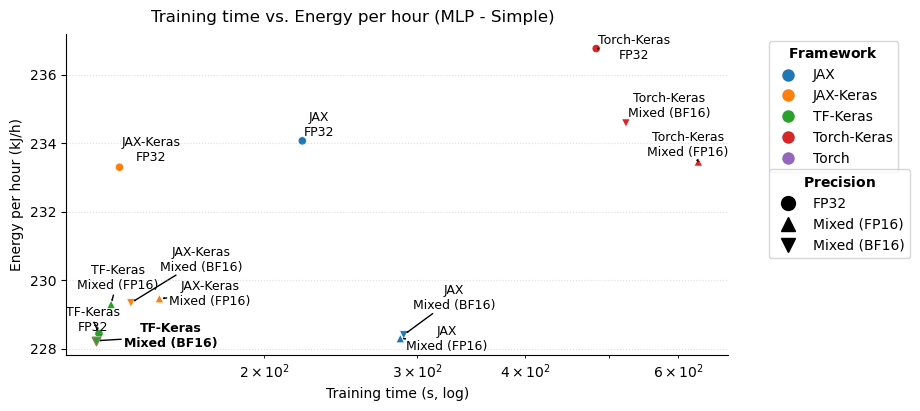

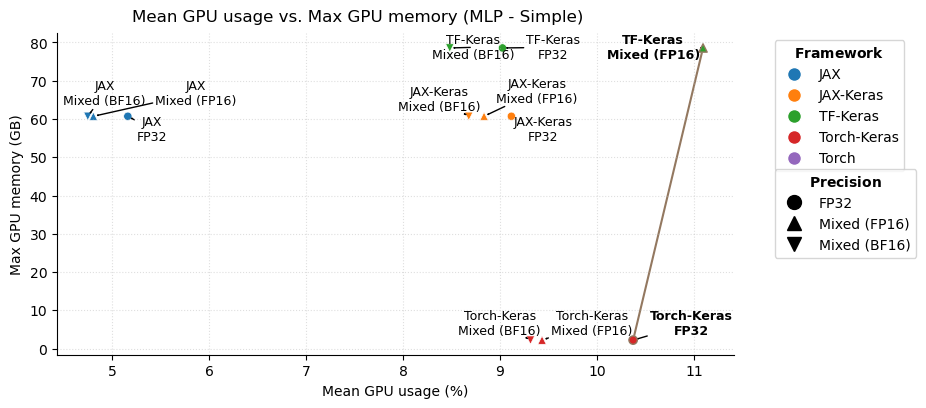

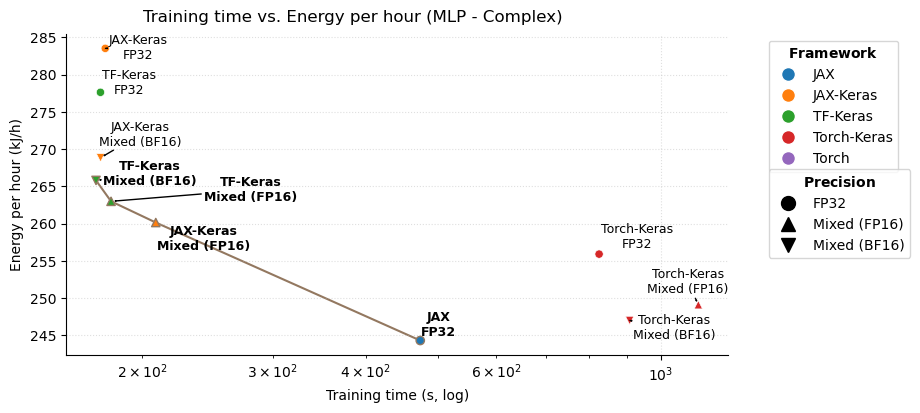

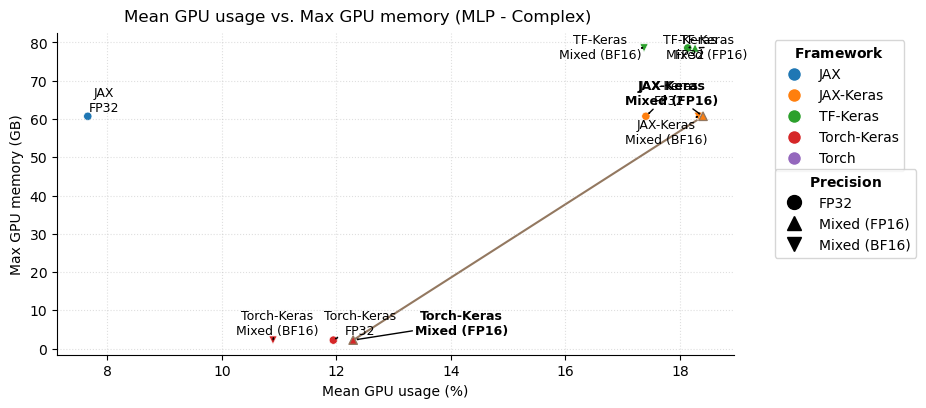

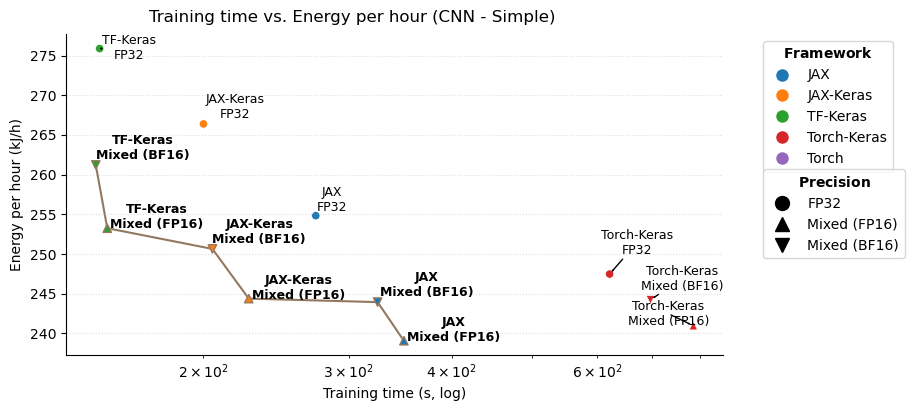

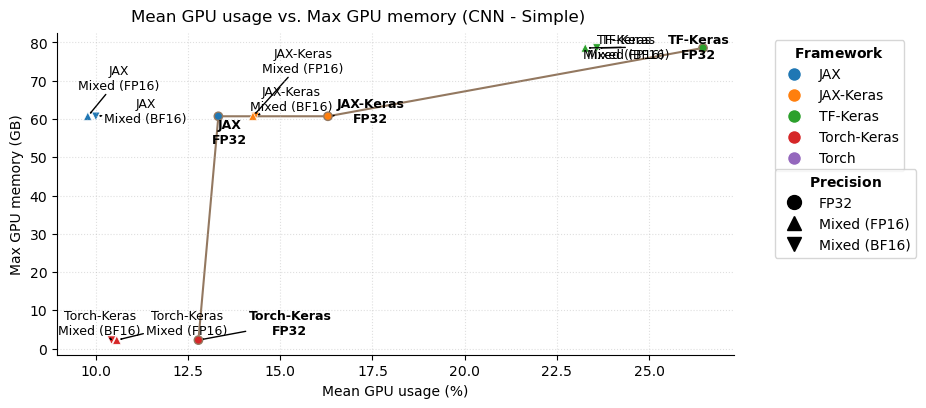

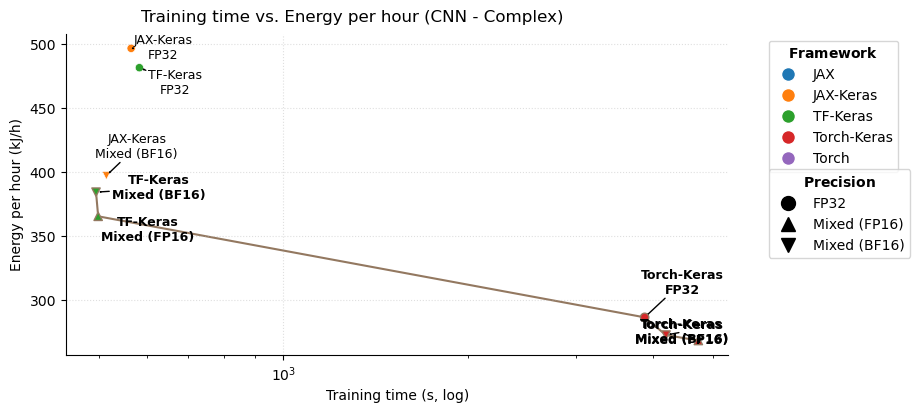

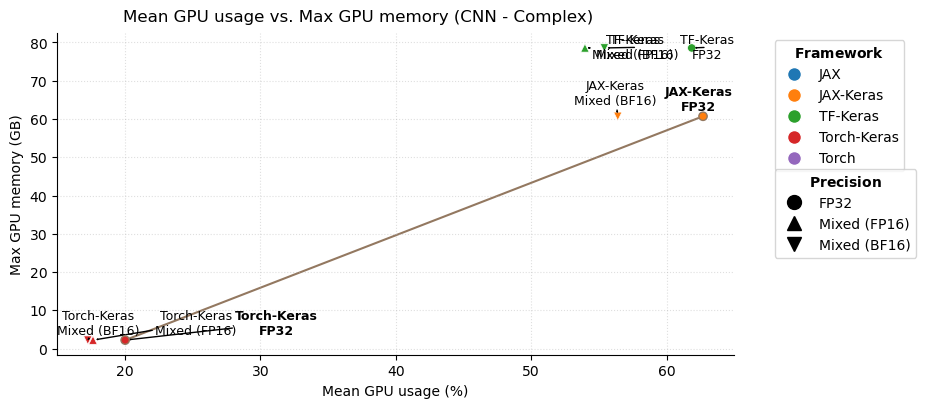

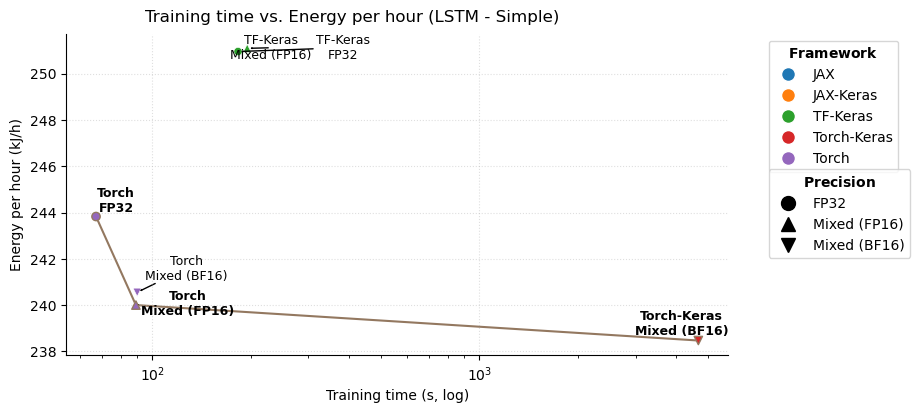

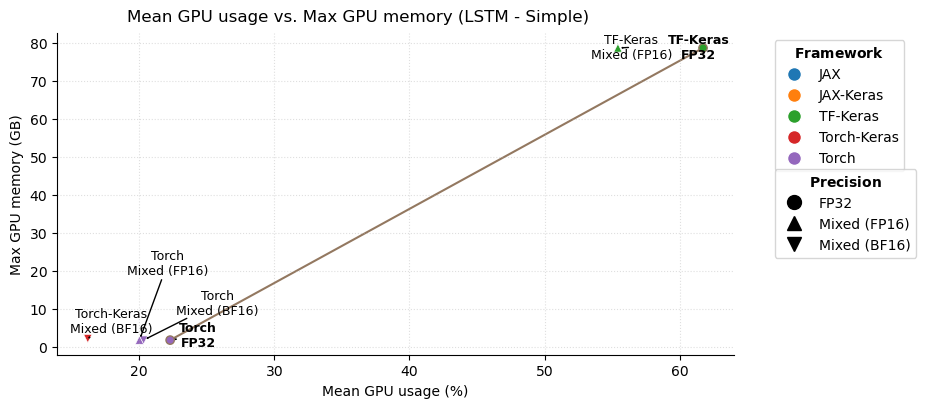

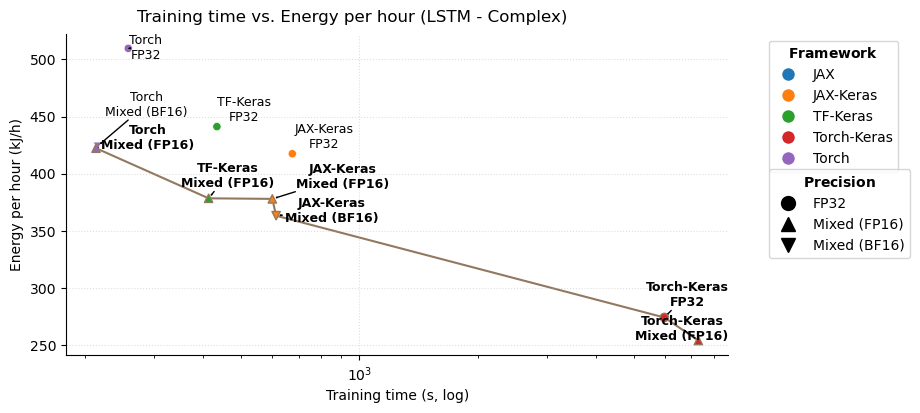

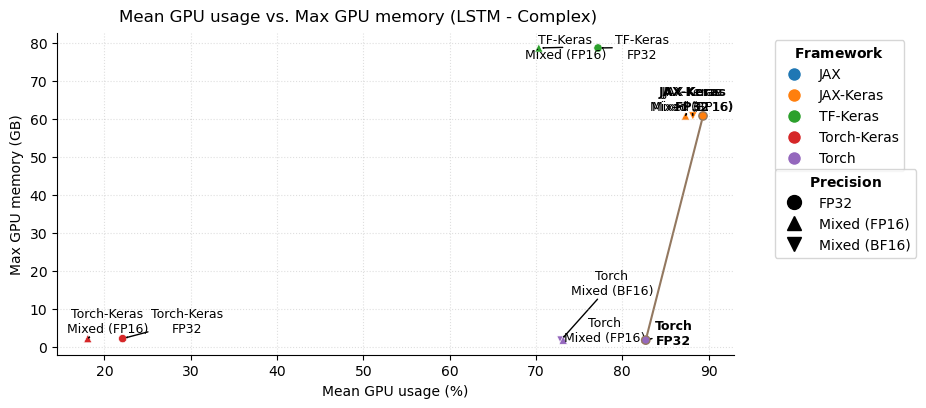

In [125]:
print(metrics_cfg.keys())
for model in orders["model_type"]:
    for complexity in orders["model_complexity"]:
        plot_versus(filtered_df, model, complexity, "training_time", "energy_per_hour", log_x=True, log_y=False)
        plot_versus(filtered_df, model, complexity, "train_gpu_utilization_mean", "max_memory")

In [126]:
1+1

2